## Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

# preprocess, split and metric
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,plot_confusion_matrix,precision_recall_curve,roc_curve,make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import preprocessing

# classifier algo
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#!conda install -c conda-forge py-xgboost
import xgboost as xgb

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

#random
np.random.seed(42)
import random
random.seed(42)

# Settings
import warnings
warnings.filterwarnings("ignore")
import time
pd.set_option('display.max_columns', None)


C:\Users\nguye_5159g\anaconda3\envs\newbase\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## EDA function

In [2]:
# calculate upper and lower bound
def upper_whisker(feature):
    if type(feature) == str: 
        feature=df[feature]
    Q1 ,Q3 = feature.quantile([0.25,0.75])
    upper = Q3 + 1.5*(Q3 - Q1)
    return upper
def lower_whisker(feature):
    if type(feature) == str: 
        feature=df[feature]
    Q1 ,Q3 = feature.quantile([0.25,0.75])
    lower = Q1 - 1.5*(Q3 - Q1)
    return lower

In [3]:
# box + kde plot for numerical variables
def histbox(feature, kde=True, bins=20, outlier=True, hue=None, line=0):
    # input 'feature' either as string input 'column name' or pd.Series df['column_name']
    # if input string (column name), convert to pd.Series
    if type(feature) == str: 
        feature=df[feature]
    if outlier:
        non_zero = feature[feature!=0].count()
        print(f'Non-zero values: {non_zero} ({round(100*non_zero/feature.notna().sum(),2)}% of total non null), null: {feature.isna().sum()}')
        print(f'Upper whisker: {round(upper_whisker(feature),2)}, amount: {(feature>upper_whisker(feature)).sum()}')
        print(f'Lower whisker: {round(lower_whisker(feature),2)}, amount: {(feature<lower_whisker(feature)).sum()}')
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(6,3), gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(feature, ax=ax_box, showmeans=True)
    if line !=0:
        ax_box.axvline(line)
        ax_hist.axvline(line)
    if hue!=None:
        if type(hue) == str: 
            hue=df[hue]
        
        sns.kdeplot(feature, ax=ax_hist, hue=hue, alpha=0.2)
    else:
        sns.histplot(feature, ax=ax_hist, kde=kde, bins=bins, edgecolor=None)
    ax_box.set(xlabel='')
    plt.show

In [4]:
# stacked plot for categorical
def stacked(feature, figsize=(6,3)):
    if type(feature) == str: 
        feature=df[feature]
    pd.crosstab(feature,df['Default']).plot(kind='bar',stacked=True,figsize=figsize)
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

In [53]:
# scatterplot for 2 numerical feature, with option to enable kde plot
def make_scatter(data_x,data_y,data_hue='Default', kde=False, alpha = 0.03):
    if type(data_x) == str:
        data_x = df[data_x]
    if type(data_y) == str:
        data_y = df[data_y]
    if type(data_hue) == str:
        data_hue = df[data_hue]
    fig, [ax1,ax2,ax3] = plt.subplots(ncols=3, sharex=True, sharey=True,figsize=(15,4))  
    color_dict = dict({data_hue.value_counts().index[0]:'steelblue',data_hue.value_counts().index[1]:'darkorange'})
    sns.scatterplot(y=data_y, x = data_x, hue = data_hue, alpha = alpha, s=40, palette = color_dict, ax = ax1)
    sns.scatterplot(y=data_y[data_hue == data_hue.value_counts().index[0]], x = data_x[data_hue == data_hue.value_counts().index[0]],hue = data_hue, alpha = alpha/2, s=30, palette = color_dict, ax = ax2)
    sns.scatterplot(y=data_y[data_hue == data_hue.value_counts().index[1]], x = data_x[data_hue == data_hue.value_counts().index[1]],hue = data_hue, alpha = alpha/2, s=30, palette = color_dict, ax = ax3)
    plt.show()
    if kde == True:
        fig, [ax1,ax2,ax3] = plt.subplots(ncols=3, sharex=True, sharey=False,figsize=(15,2))
        color_dict = dict({data_hue.value_counts().index[0]:'steelblue',data_hue.value_counts().index[1]:'darkorange'})
        sns.kdeplot(data_x, hue = data_hue, palette = color_dict, ax = ax1)
        sns.boxplot(data_x[data_hue == data_hue.value_counts().index[0]], ax = ax2)
        sns.boxplot(data_x[data_hue == data_hue.value_counts().index[1]], ax = ax3)

In [6]:
# boxplot for numerical + categorical feature, with option for custom sorting
def boxcount(data_y, data_x, data_hue='Default', sort_order=None, figsize=(6,6)):
    if type(data_y)==str:
        data_y = df[data_y]
    if type(data_x)==str:
        data_x = df[data_x]
    if type(data_hue)==str:
        data_hue = df[data_hue]
    fig,[ax1,ax2] = plt.subplots(2, figsize=figsize)  
    sns.boxplot(y = data_y, x=data_x, hue=data_hue, order=sort_order, ax=ax1)
    sns.countplot(data_x,hue=data_hue,order=sort_order, ax=ax2)
    if data_hue is not None:
        ax1.legend(bbox_to_anchor=(1.1, 1.05)),ax2.legend(bbox_to_anchor=(1.1, 1.05))
    plt.tight_layout()
    plt.show()

In [7]:
# heatmap for 2 categorical features
def catheatmap(data_y, data_x, figsize=(6,3), annot=False, cmap='mako', ax=None):
    if type(data_x)==str:
        data_x = df[data_x]
    if type(data_y)==str:
        data_y = df[data_y]    
    df_plot=pd.DataFrame(columns=sorted(data_x.unique()))
    for col in df_plot.columns:
        df_plot[col]=df[data_x==col].groupby(data_y).count()['Default']    
    plt.figure(figsize=figsize)
    sns.heatmap(df_plot,annot=annot,cmap=cmap, ax=ax)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    del df_plot

## 1. Data

In [265]:
df = pd.read_csv('download\\training_data.csv')
df_submit = pd.read_csv('download\\testing_data.csv')
df.head(10)

ID Date_Of_Disbursement  Business  Jobs_Reatained  Jobs_Created   \
0   0            31-Jul-91  Existing               0              0   
1   1            30-Apr-06       New               0              6   
2   2            30-Jun-04  Existing               4              0   
3   3            31-Jan-06       New               9              1   
4   4            31-Dec-04  Existing               4              0   
5   5            30-Apr-06  Existing               3              0   
6   6      10/31/2007 0:00       New               3              3   
7   7            30-Apr-96  Existing               0              0   
8   8            31-Aug-09       New               1              3   
9   9            31-Jul-02  Existing              20              2   

  Year_Of_Commitment  Guaranteed_Approved _Loan  \
0                1991             Rs.33121600.0   
1                2006             Rs.32735520.0   
2                2004              Rs.1422400.0   
3                2006              Rs.2032000.0   
4                2005             Rs.22981920.0   
5                2001               Rs.203200.0   
6                2007              Rs.1016000.0   
7                1996              Rs.3352800.0   
8                2007              Rs.4925568.0   
9                2002               Rs.406400.0   

                   Borrower_Name  Low_Documentation_Loan Demography  \
0      STANDARD PARTS CORPORATION                     No  Undefined   
1            FRANK & KERI AMESTOY                     No      Urban   
2                TELECOMMQC L L C                     No      Urban   
3  K & A AUTOMOTIVE, INC. DBA MUF                     No      Urban   
4                    SUNBEAM DELI                     No      Urban   
5             OFFICE REFRESHMENTS                     No      Urban   
6          Diffusion Limited, LLC                     No      Urban   
7          VALI CINEMA & DRIVE IN                     No  Undefined   
8             J & K Fitness, Inc.                     No      Urban   
9          SALON PROGRESSIONS LLC                     No      Urban   

  State_Of_Bank     ChargedOff_Amount  Borrower_City Borrower_State  \
0            AP                 Rs.0.0        Mumbai    Maharashtra   
1            TR         Rs.38283367.68         Delhi          Delhi   
2            AS                 Rs.0.0     Bengaluru      Karnataka   
3            BR                 Rs.0.0     Ahmedabad        Gujarat   
4            TR         Rs.22862519.68     Hyderabad      Telangana   
5            BR                 Rs.0.0       Chennai     Tamil Nadu   
6            AS  Rs.2022896.6400000001       Kolkata    West Bengal   
7            CG                 Rs.0.0          Pune    Maharashtra   
8            AR                 Rs.0.0        Jaipur      Rajasthan   
9            GJ                 Rs.0.0         Surat        Gujarat   

  Gross_Amount_Balance  Count_Employees  Classification_Code   \
0               Rs.0.0               38                     0   
1               Rs.0.0                6                451120   
2               Rs.0.0                4                541618   
3               Rs.0.0                7                811112   
4               Rs.0.0                4                722211   
5               Rs.0.0                3                454210   
6               Rs.0.0                2                541618   
7               Rs.0.0               10                512131   
8               Rs.0.0                1                713940   
9               Rs.0.0               16                812112   

  Loan_Approved_Gross Gross_Amount_Disbursed    Loan_Term Commitment_Date  \
0       Rs.40640000.0            Rs.40640000.0        126        2-Apr-91   
1       Rs.43647360.0            Rs.43647360.0        123       10-Apr-06   
2        Rs.2844800.0            Rs.5961400.32         90       25-May-04   
3        Rs.4064000.0             Rs.4064000.0        126       21-Dec-

In [224]:
print('Train set:')
print(df.isna().sum()[df.isna().sum()!=0])
print('*'*40)
print('Test set:')
print(df_submit.isna().sum()[df_submit.isna().sum()!=0])

Train set:
Date_Of_Disbursement      235
Business                   15
Borrower_Name               3
Low_Documentation_Loan    367
Revolving_Credit_Line     491
dtype: int64
****************************************
Test set:
Date_Of_Disbursement        108
Business                      6
Borrower_Name                 2
Low_Documentation_Loan      133
Borrower_State               49
Revolving_Credit_Line     13825
dtype: int64


In [225]:
df.duplicated().value_counts(), df_submit.duplicated().value_counts()

(False    105000
 dtype: int64,
 False    45000
 dtype: int64)

# 2 Pre processing
run below code then start from 2.4 (skip 2.1-2.3)

In [73]:
columns_reorder = [
    # 'ID',
    # Business related
    'Business',
    'Jobs_Reatained',
    'Jobs_Created',
    'Count_Employees', 
    'Classification_Code',
    'Code_Franchise',
    'Demography',
    
    # Loan related
    'Loan_Term',
    'Guaranteed_Approved_Loan',
    'Loan_Approved_Gross', 
    'Gross_Amount_Disbursed',
    'Gross_Amount_Balance',
    'ChargedOff_Amount',
    'Low_Documentation_Loan',
    'Revolving_Credit_Line',
    'Primary_Loan_Digit',
    
    # Date
    'Commitment_Date',     
    'Date_Of_Disbursement', 
    'Year_Of_Commitment',
    
    # Name and city/state
    'Borrower_Name',
    'Borrower_City', 
    'Borrower_State', 
    'Name_Of_Bank',
    'State_Of_Bank',
    'Default'
]

rs_remove = ['Guaranteed_Approved_Loan',
             'Loan_Approved_Gross',
             'Gross_Amount_Disbursed',
             'Gross_Amount_Balance',
             'ChargedOff_Amount']

loan_rename = {
    'Guaranteed_Approved_Loan': 'Guaranteed_Approved',
    'Loan_Approved_Gross': 'Gross_Approved',
    'Gross_Amount_Disbursed': 'Gross_Disbursed',
}

In [97]:
# preprocess for EDA
def preprocess_pipeline(df_train = pd.read_csv('download\\training_data.csv'), df_submit = pd.read_csv('download\\testing_data.csv')):
    # remove space
    df_train.columns = df_train.columns.str.replace(' ', '')
    df_submit.columns = df_submit.columns.str.replace(' ', '')

    # column rearrange
    df_train = df_train[columns_reorder]
    df_submit = df_submit[columns_reorder[:-1]]

    # remove Rs.
    for feature in rs_remove:
        df_train[feature] = df_train[feature].str.replace('Rs.', '').astype(float)
        df_submit[feature] = df_submit[feature].str.replace('Rs.', '').astype(float)
        
    # loan rename
    df_train.rename(columns = loan_rename, inplace=True)
    df_submit.rename(columns = loan_rename, inplace=True)

    # fill na in category with NaN for analysis
    for feature in ['Business', 'Revolving_Credit_Line']:
        df_train[feature].fillna('NaN', inplace=True)
        df_submit[feature].fillna('NaN', inplace=True)
        
    # create classification group
    df_train['Classification_Group'] = df_train['Classification_Code'].apply(lambda x: 'Class_'+str(x)[0])
    df_submit['Classification_Group'] = df_submit['Classification_Code'].apply(lambda x: 'Class_'+str(x)[0])

    # date to month/year column
    df_train['Commitment_Month'] = pd.DatetimeIndex(df_train['Commitment_Date']).month
    df_train['Commitment_Year'] = pd.DatetimeIndex(df_train['Commitment_Date']).year
    df_train['Commitment_Year'][df_train['Commitment_Year']>2022] = df_train['Commitment_Year'][df_train['Commitment_Year']>2022] - 100
    
    df_train['Disbursement_Month'] = pd.DatetimeIndex(df_train['Date_Of_Disbursement']).month
    df_train['Disbursement_Year'] = pd.DatetimeIndex(df_train['Date_Of_Disbursement']).year
    df_train['Disbursement_Year'][df_train['Disbursement_Year']>2022] = df_train['Disbursement_Year'][df_train['Disbursement_Year']>2022] - 100
    df_train.drop(columns=['Commitment_Date','Date_Of_Disbursement'], inplace=True)
    
    df_submit['Commitment_Month'] = pd.DatetimeIndex(df_submit['Commitment_Date']).month
    df_submit['Commitment_Year'] = pd.DatetimeIndex(df_submit['Commitment_Date']).year
    df_submit['Commitment_Year'][df_submit['Commitment_Year']>2022] = df_submit['Commitment_Year'][df_submit['Commitment_Year']>2022] - 100
    
    df_submit['Disbursement_Month'] = pd.DatetimeIndex(df_submit['Date_Of_Disbursement']).month
    df_submit['Disbursement_Year'] = pd.DatetimeIndex(df_submit['Date_Of_Disbursement']).year
    df_submit['Disbursement_Year'][df_submit['Disbursement_Year']>2022] = df_submit['Disbursement_Year'][df_submit['Disbursement_Year']>2022] - 100
    
    df_submit.drop(columns=['Commitment_Date','Date_Of_Disbursement'], inplace=True)
    
    # add Quarter
    df_train['Commitment_Quarter'] = df_train['Commitment_Month'].apply(lambda x: f'Q{(x-1)//3 + 1}')
    df_submit['Commitment_Quarter'] = df_submit['Commitment_Month'].apply(lambda x: f'Q{(x-1)//3 + 1}')
    
    df_train['Disbursement_Quarter'] = df_train['Disbursement_Month'].apply(lambda x: f'Q{((x-1)//3 + 1):.0f}')
    df_submit['Disbursement_Quarter'] = df_submit['Disbursement_Month'].apply(lambda x: f'Q{((x-1)//3 + 1):.0f}')
    
    # Year_Of_Commitment to int
    df_train['Year_Of_Commitment'][df_train['Year_Of_Commitment']=='1976A']=1976
    df_train['Year_Of_Commitment'] = df_train['Year_Of_Commitment'].astype(int)
    df_submit['Year_Of_Commitment'][df_submit['Year_Of_Commitment']=='1976A']=1976
    df_submit['Year_Of_Commitment'] = df_submit['Year_Of_Commitment'].astype(int)
    
    # drop Primary_Loan_Digit
    df_train.drop(columns='Primary_Loan_Digit', inplace=True)
    df_submit.drop(columns='Primary_Loan_Digit', inplace=True)

    return df_train, df_submit

df, df_submit = preprocess_pipeline()

## 2.1 Overview

In [ ]:
df = pd.read_csv('download\\training_data.csv')
df_submit = pd.read_csv('download\\testing_data.csv')

In [17]:
for feature in df.columns[1:]:
    print(f'Feature: {feature}')
    print(df[feature].value_counts(dropna=False))
    print('*'*50)

Feature: Date_Of_Disbursement
31-Jul-95    1111
30-Apr-95    1077
31-Jan-95    1064
31-Oct-94     946
31-Mar-06     922
             ... 
13-Dec-94       1
11-Feb-80       1
23-May-12       1
14-Jan-81       1
2-May-80        1
Name: Date_Of_Disbursement, Length: 3506, dtype: int64
**************************************************
Feature: Business
Existing    75091
New         29789
0             105
NaN            15
Name: Business, dtype: int64
**************************************************
Feature: Jobs_Reatained
0      48776
1      11242
2       9526
3       6452
4       4864
       ...  
199        1
104        1
177        1
220        1
400        1
Name: Jobs_Reatained, Length: 191, dtype: int64
**************************************************
Feature: Jobs_Created 
0       72288
1        8063
2        7256
3        3472
4        2485
        ...  
1016        1
125         1
167         1
205         1
1000        1
Name: Jobs_Created , Length: 128, dtype: int64
******

## 2.2 Minor stuff
- Remove space in column name
- Rearrange columns

In [49]:
# remove space
df.columns = df.columns.str.replace(' ', '')
df_submit.columns = df_submit.columns.str.replace(' ', '')

In [50]:
# reordering
columns_reorder = [
    'ID',
    # Business related
    'Business',
    'Jobs_Reatained',
    'Jobs_Created',
    'Count_Employees', 
    'Classification_Code',
    'Code_Franchise',
    'Demography',
    
    # Loan related
    'Loan_Term',
    'Guaranteed_Approved_Loan',
    'Loan_Approved_Gross', 
    'Gross_Amount_Disbursed',
    'Gross_Amount_Balance',
    'ChargedOff_Amount',
    'Low_Documentation_Loan',
    'Revolving_Credit_Line',
    'Primary_Loan_Digit',
    
    # Date
    'Commitment_Date',     
    'Date_Of_Disbursement', 
    'Year_Of_Commitment',
    
    # Name and city/state
    'Borrower_Name',
    'Borrower_City', 
    'Borrower_State', 
    'Name_Of_Bank',
    'State_Of_Bank',
    
    # Target
    'Default'
]

df = df[columns_reorder]
df_submit = df_submit[columns_reorder[:-1]]

## 2.3 Correct Formatting

In [150]:
for feature in df.columns[1:]:
    print(f'Feature: {feature}')
    print(df[feature].value_counts(dropna=False))
    print('*'*50)

Feature: Business
Existing    75091
New         29789
0             105
NaN            15
Name: Business, dtype: int64
**************************************************
Feature: Jobs_Reatained
0      48776
1      11242
2       9526
3       6452
4       4864
       ...  
199        1
104        1
177        1
220        1
400        1
Name: Jobs_Reatained, Length: 191, dtype: int64
**************************************************
Feature: Jobs_Created
0       72288
1        8063
2        7256
3        3472
4        2485
        ...  
1016        1
125         1
167         1
205         1
1000        1
Name: Jobs_Created, Length: 128, dtype: int64
**************************************************
Feature: Count_Employees
1       18778
2       16305
4       15757
3       10950
5        5329
        ...  
168         1
756         1
4051        1
326         1
183         1
Name: Count_Employees, Length: 282, dtype: int64
**************************************************
Feature: Cla

In [55]:
# Remove Rs. and convert to float
rs_remove = ['Guaranteed_Approved_Loan',
             'Loan_Approved_Gross',
             'Gross_Amount_Disbursed',
             'Gross_Amount_Balance',
             'ChargedOff_Amount']

for feature in rs_remove:
    df[feature] = df[feature].str.replace('Rs.', '').astype(float)
    # df_submit

In [58]:
# Fill na in cat columns with NaN for analysis
for feature in ['Business', 'Revolving_Credit_Line']:
    df[feature].fillna('NaN', inplace=True)

In [149]:
# create month and year column
df['Commitment_Month'] = pd.DatetimeIndex(df['Commitment_Date']).month
df['Commitment_Year'] = pd.DatetimeIndex(df['Commitment_Date']).year
df['Disbursement_Month'] = pd.DatetimeIndex(df['Date_Of_Disbursement']).month
df['Disbursement_Year'] = pd.DatetimeIndex(df['Date_Of_Disbursement']).year
df.drop(columns=['Commitment_Date','Date_Of_Disbursement'], inplace=True)

## 2.4 New feature

### Classification_Code to group

In [93]:
df, df_submit = preprocess_pipeline()

In [76]:
df = pd.DataFrame()
df_submit = pd.DataFrame()
df['Classification_Group'] = df['Classification_Code'].apply(lambda x: 'Class_'+str(x)[0])
df_submit['Classification_Group'] = df_submit['Classification_Code'].apply(lambda x: 'Class_'+str(x)[0])

# 3. EDA

Date_Of_Disbursement: convert to dtype(year column) (Disbursement to date (in month?))

Business: business type
- what are the job metrics of each type?
- loan def in each type?
- range of year commitment?
- approve loan for each type
- low doc:?

Guaranteed_Approved :
- any correlation to job created/retain
- range in each low doc?

Low_Documentation_Loan: 

ChargedOff_Amount: ?

'Demography',look at range approved and business type in each demography


Later:
'Borrower_City', 'Borrower_State': 
city/state: sorting of indian city/state metrics (gdp, gdp percap, )
State_Of_Bank

## 3.0 Summary

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Business                  105000 non-null  object 
 1   Jobs_Reatained            105000 non-null  int64  
 2   Jobs_Created              105000 non-null  int64  
 3   Count_Employees           105000 non-null  int64  
 4   Classification_Code       105000 non-null  int64  
 5   Code_Franchise            105000 non-null  int64  
 6   Demography                105000 non-null  object 
 7   Loan_Term                 105000 non-null  int64  
 8   Guaranteed_Approved_Loan  105000 non-null  float64
 9   Loan_Approved_Gross       105000 non-null  float64
 10  Gross_Amount_Disbursed    105000 non-null  float64
 11  Gross_Amount_Balance      105000 non-null  float64
 12  ChargedOff_Amount         105000 non-null  float64
 13  Low_Documentation_Loan    104633 non-null  o

In [270]:
df.describe().T

count          mean           std       min  \
Jobs_Reatained            105000.0  1.268865e+01  2.705442e+02       0.0   
Jobs_Created              105000.0  1.037925e+01  2.703408e+02       0.0   
Count_Employees           105000.0  9.904248e+00  5.815706e+01       0.0   
Classification_Code       105000.0  4.059183e+05  2.603360e+05       0.0   
Code_Franchise            105000.0  2.707202e+03  1.266061e+04       0.0   
Loan_Term                 105000.0  1.564384e+02  1.164127e+02       0.0   
Guaranteed_Approved_Loan  105000.0  1.151738e+07  1.818916e+07   40640.0   
Loan_Approved_Gross       105000.0  1.492200e+07  2.262852e+07   81280.0   
Gross_Amount_Disbursed    105000.0  1.563878e+07  2.288627e+07  325120.0   
Gross_Amount_Balance      105000.0  7.637843e+01  2.431197e+04       0.0   
ChargedOff_Amount         105000.0  1.711913e+06  6.520106e+06       0.0   
Default                   105000.0  2.771810e-01  4.476087e-01       0.0   
Commitment_Month          105000.0  6.489067e+00  3.364938e+00       1.0   
Commitment_Year           105000.0  2.001226e+03  5.959074e+00    1969.0   
Disbursement_Month        104765.0  6.372892e+00  3.433639e+00       1.0   
Disbursement_Year         104765.0  2.001498e+03  5.877451e+00    1969.0   

                                25%        50%          75%           max  
Jobs_Reatained                  0.0        1.0         4.00  8.800000e+03  
Jobs_Created                    0.0        0.0         1.00  8.800000e+03  
Count_Employees                 2.0        4.0         9.00  7.200000e+03  
Classification_Code        236115.0   447110.0    561740.00  9.281200e+05  
Code_Franchise                  0.0        1.0         1.00  9.200600e+04  
Loan_Term                      90.0      126.0       180.00  6.920000e+02  
Guaranteed_Approved_Loan  1625600.0  4226560.0  13167360.00  3.657600e+08  
Loan_Approved_Gross       2600960.0  6502400.0  16906240.00  4.064000e+08  
Gross_Amount_Disbursed    3251200.0  7802880.0  18125785.44  7.311136e+08  
Gross_Amount_Balance            0.0        0.0         0.00  7.876682e+06  
ChargedOff_Amount               0.0        0.0    617016.80  1.625599e+08  
Default                         0.0        0.0         1.00  1.000000e+00  
Commitment_Month                4.0        6.0         9.00  1.200000e+01  
Commitment_Year              1997.0     2003.0      2006.00  2.014000e+03  
Disbursement_Month              4.0        7.0        10.00  1.200000e+01  
Disbursement_Year            1997.0     2003.0      2006.00  2.014000e+03

In [271]:
df.describe(include=["object"]).T

count  unique              top   freq
Business                105000       4         Existing  75091
Demography              105000       3            Urban  57598
Low_Documentation_Loan  104633       7               No  92135
Revolving_Credit_Line   105000      12               No  48122
Year_Of_Commitment      105000      91             2007   6769
Borrower_Name           104997  101068           SUBWAY    147
Borrower_City           105000    1193           Jhansi   1504
Borrower_State          105000      41      Maharashtra  11699
Name_Of_Bank            105000     143  ICICI Bank Ltd.  11215
State_Of_Bank           105000      34               TR  15552
Commitment_Quarter      105000       4               Q3  27646
Disbursement_Quarter    105000       5               Q2  26862

## 3.1 Univariate

### Default

In [259]:
df.Default.value_counts(),df.Default.value_counts(normalize=True)

(0    75896
 1    29104
 Name: Default, dtype: int64,
 0    0.722819
 1    0.277181
 Name: Default, dtype: float64)

### Overview numeric
- Jobs_Reatained, Jobs_Created, Count_Employees => extremely right skewed, + outliers
- What is code franchise?
- Loan term: seem to round up to 120 ~ 240, 360, 480?
- What's the relationship between different loan amount?
- Commitment_Month: no clear trend
- Disbursement_Month: There seems to be a trend in first month of each quarter

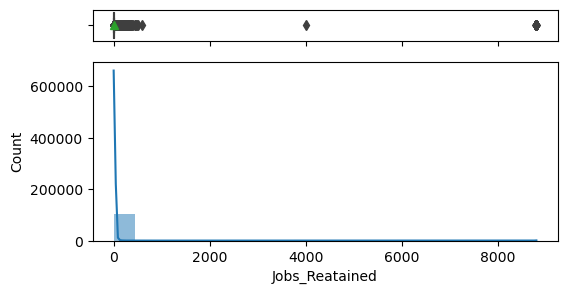

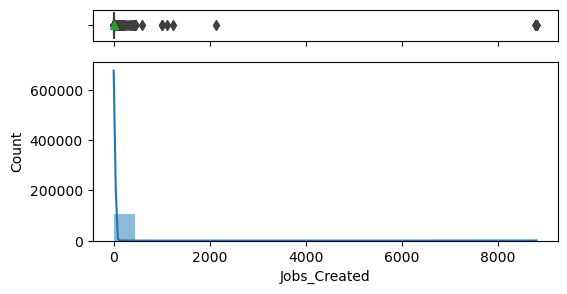

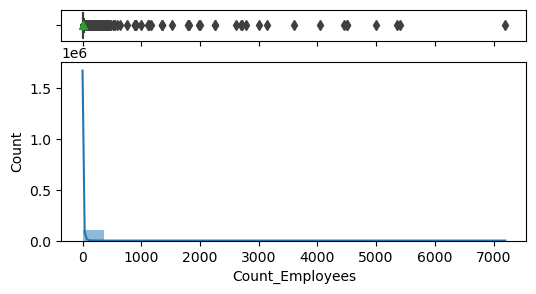

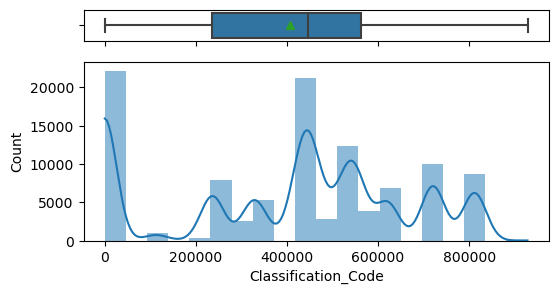

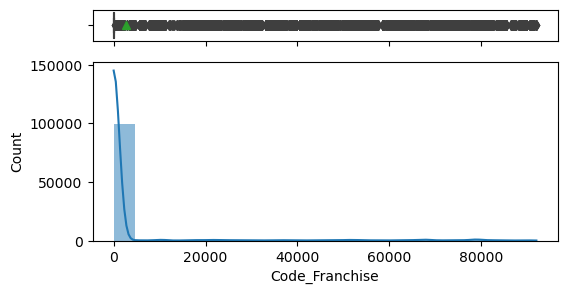

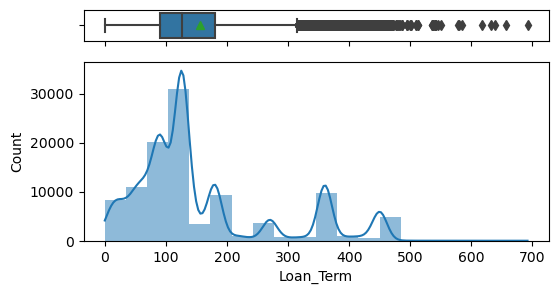

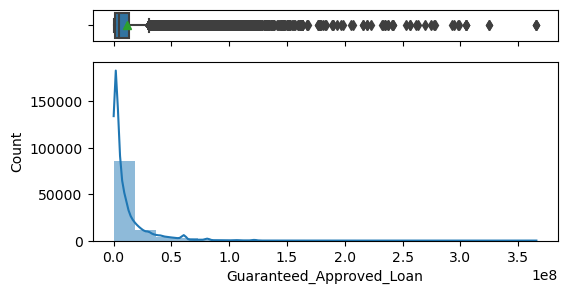

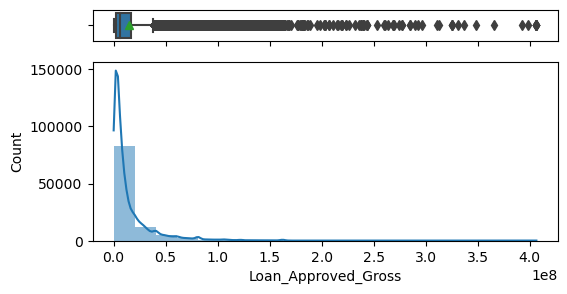

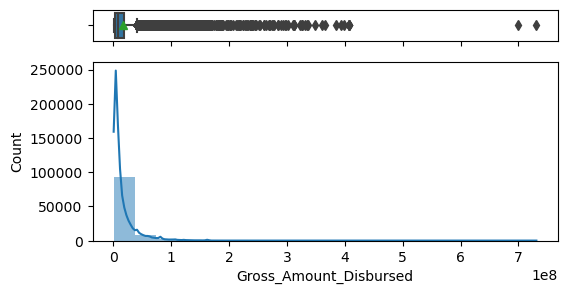

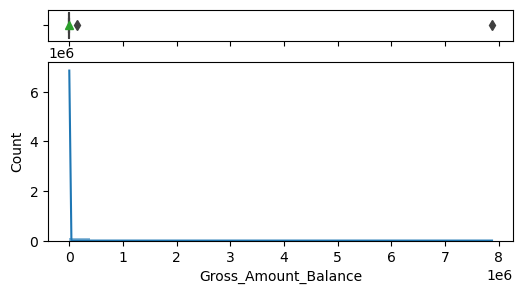

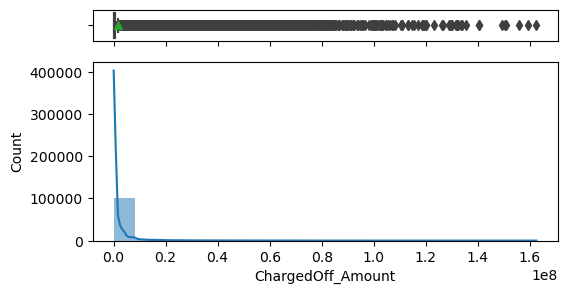

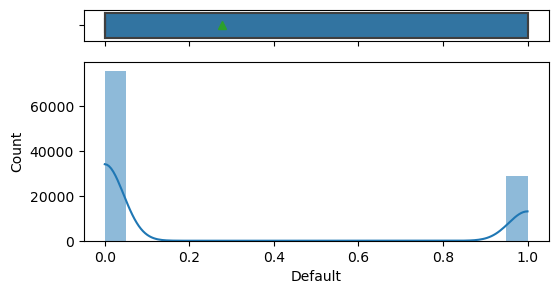

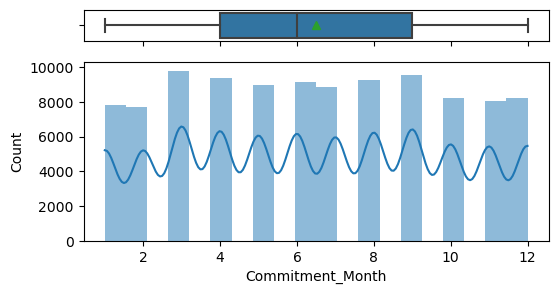

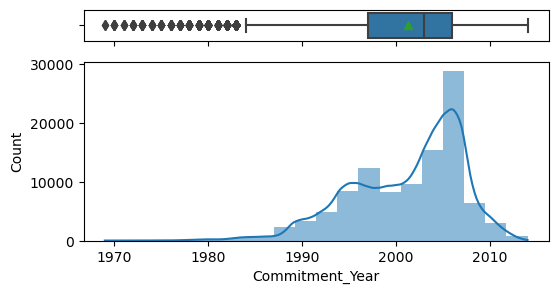

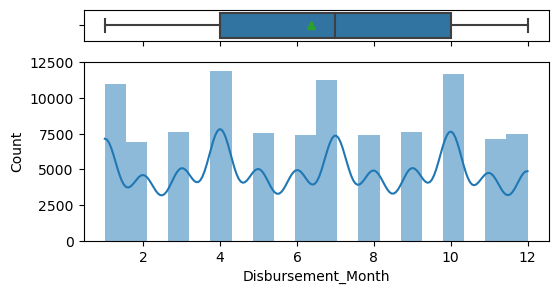

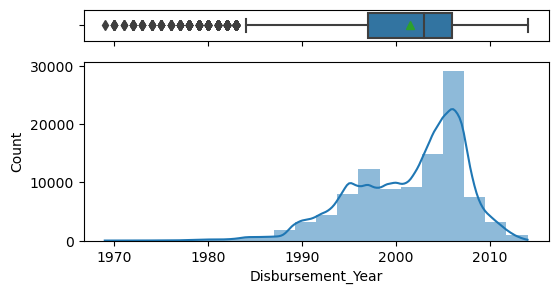

In [272]:
num_cols = df.select_dtypes(include=[np.number]).columns
for feature in num_cols:
    histbox(feature, outlier=False)

### Guaranteed_Approved_Loan
- Extremely skewed right
- Most are under 20M, while the top can go up to 300M+

Non-zero values: 105000 (100.0% of total non null), null: 0
Upper whisker: 30480000.0, amount: 10693
Lower whisker: -15687040.0, amount: 0


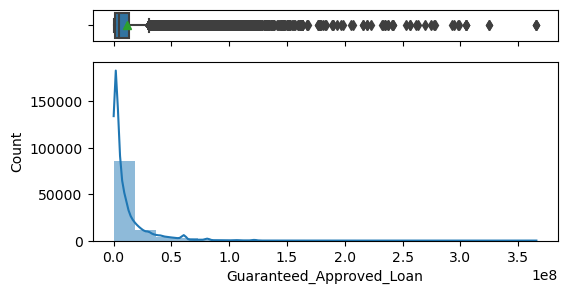

In [274]:
histbox('Guaranteed_Approved')

Non-zero values: 45000 (100.0% of total non null), null: 0
Upper whisker: 30882336.0, amount: 4614
Lower whisker: -16032480.0, amount: 0


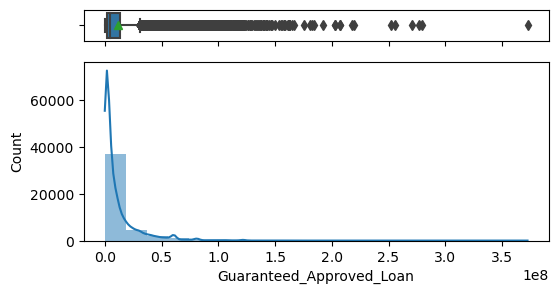

In [275]:
histbox(df_submit['Guaranteed_Approved'])

In [278]:
df.Guaranteed_Approved.max()

365760000.0

Non-zero values: 73963 (100.0% of total non null), null: 0
Upper whisker: 11277600.0, amount: 0
Lower whisker: -5140960.0, amount: 0


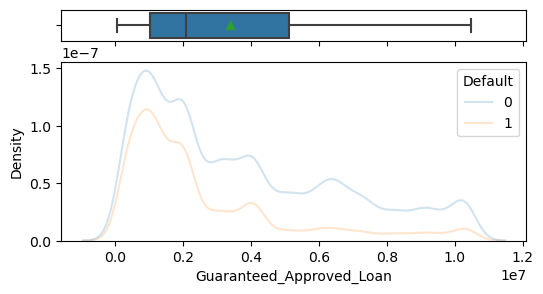

In [329]:
histbox(df.Guaranteed_Approved[df.Guaranteed_Approved<10480000], hue='Default')

Non-zero values: 31037 (100.0% of total non null), null: 0
Upper whisker: 73914000.0, amount: 1697
Lower whisker: -19964400.0, amount: 0


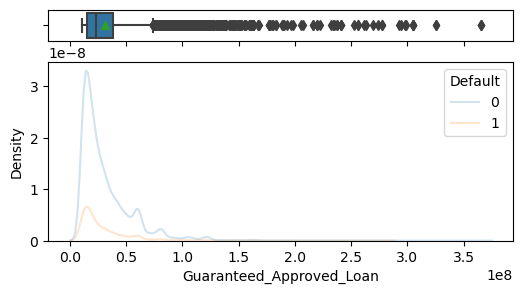

In [330]:
histbox(df.Guaranteed_Approved_Loan[df.Guaranteed_Approved_Loan>10480000], hue='Default')

### Loan_Approved_Gross
- The range slightly bigger than Guaranteed_Approved_Loan

Non-zero values: 105000 (100.0% of total non null), null: 0
Upper whisker: 38364160.0, amount: 10958
Lower whisker: -18856960.0, amount: 0


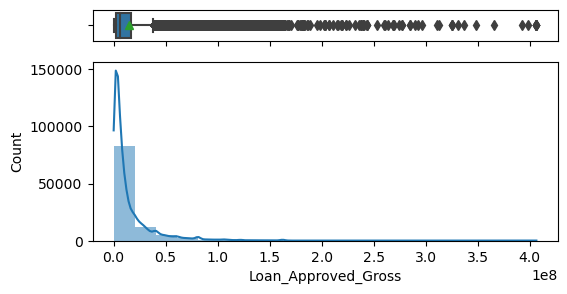

In [280]:
histbox('Loan_Approved_Gross')

Non-zero values: 105000 (100.0% of total non null), null: 0
Upper whisker: 38364160.0, amount: 10958
Lower whisker: -18856960.0, amount: 0


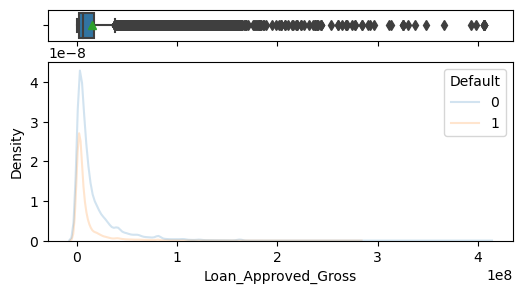

In [318]:
histbox('Loan_Approved_Gross', hue='Default')

In [317]:
df.Default[df.Loan_Approved_Gross>1e8].value_counts()

0    1242
1     227
Name: Default, dtype: int64

### Gross_Amount_Disbursed
Similar, 80% under 2e7. No clear default in upper whisker.

Non-zero values: 105000 (100.0% of total non null), null: 0
Upper whisker: 40437663.6, amount: 10532
Lower whisker: -19060678.16, amount: 0


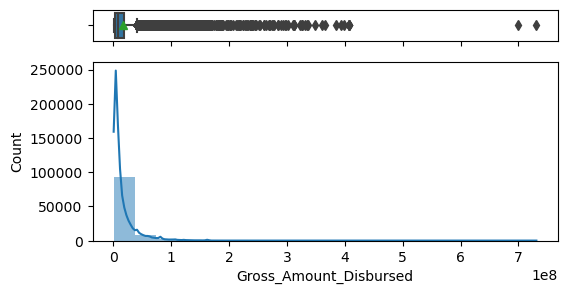

In [282]:
histbox('Gross_Amount_Disbursed')

Non-zero values: 80905 (100.0% of total non null), null: 0
Upper whisker: 19913600.0, amount: 50
Lower whisker: -8046720.0, amount: 0


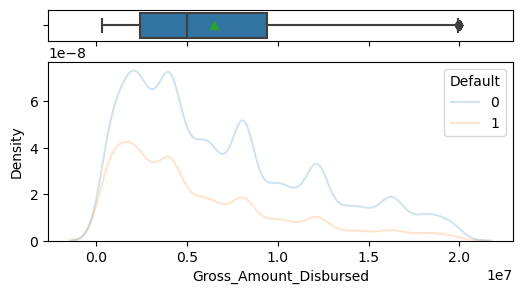

In [331]:
histbox(df.Gross_Amount_Disbursed[df.Gross_Amount_Disbursed<2e7], hue='Default')

In [313]:
df.Default[df.Gross_Amount_Disbursed>1e7].value_counts()

0    34616
1     8174
Name: Default, dtype: int64

### ChargedOff_Amount 
- Incollectable / loss amount?
- 70% = 0. The rest 30% is extremely skewed, up to 160M
- What are those chargedoff>0? => **98% of chargeoff>0 is Default**

Non-zero values: 29485 (100.0% of total non null), null: 0
Upper whisker: 13069620.8, amount: 3180
Lower whisker: -5904707.52, amount: 0


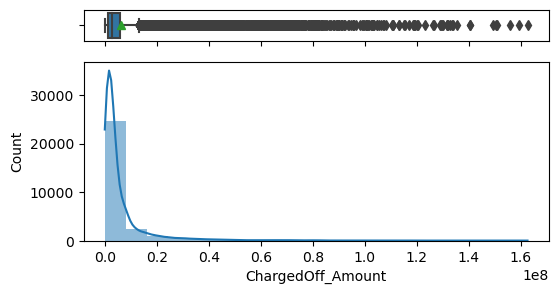

In [305]:
histbox(df.ChargedOff_Amount[df.ChargedOff_Amount>0])

Non-zero values: 29485 (100.0% of total non null), null: 0
Upper whisker: 13069620.8, amount: 3180
Lower whisker: -5904707.52, amount: 0


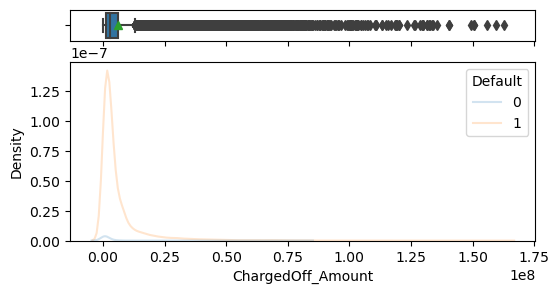

In [332]:
histbox(df.ChargedOff_Amount[df.ChargedOff_Amount>0] , hue='Default')

In [308]:
df[df.ChargedOff_Amount>0]['Default'].value_counts(),df[df.ChargedOff_Amount>0]['Default'].value_counts(normalize=True),

(1    28980
 0      505
 Name: Default, dtype: int64,
 1    0.982873
 0    0.017127
 Name: Default, dtype: float64)

In [333]:
df.Default.value_counts()

0    75896
1    29104
Name: Default, dtype: int64

In [342]:
df_ID = pd.read_csv('download\\testing_data.csv',usecols=['ID'])
df_ID['Default']= df_submit['ChargedOff_Amount'].map(lambda x: 1 if x>0 else 0)
df_ID.to_csv('fun.csv', index=None)

### Gross_Amount_Balance
=> should be dropped

Non-zero values: 2 (0.0% of total non null), null: 0
Upper whisker: 0.0, amount: 2
Lower whisker: 0.0, amount: 0


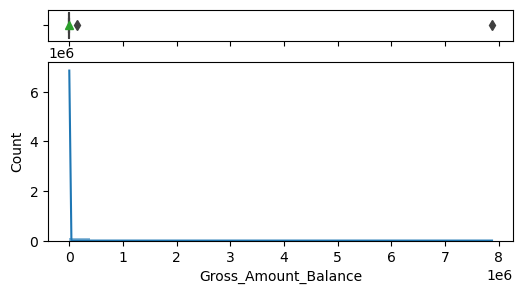

In [284]:
histbox('Gross_Amount_Balance')

In [323]:
df.Default[df.Gross_Amount_Balance>0]

14627    0
51600    0
Name: Default, dtype: int64

### Jobs_Reatained
What is that 4000+

Non-zero values: 56224 (53.55% of total non null), null: 0
Upper whisker: 10.0, amount: 10352
Lower whisker: -6.0, amount: 0


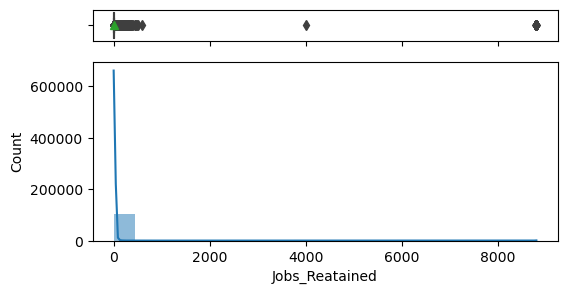

In [285]:
histbox('Jobs_Reatained')

Non-zero values: 10352 (100.0% of total non null), null: 0
Upper whisker: 54.0, amount: 1050
Lower whisker: -10.0, amount: 0


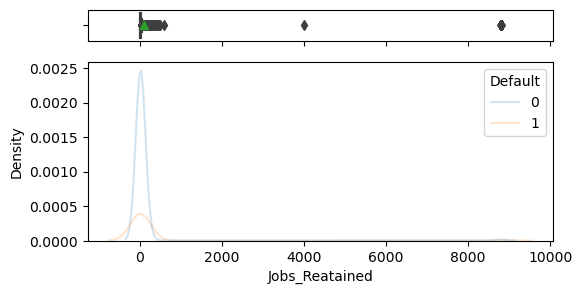

In [347]:
histbox(df['Jobs_Reatained'][df['Jobs_Reatained']>10], hue='Default')

Non-zero values: 44047 (47.45% of total non null), null: 0
Upper whisker: 7.5, amount: 3023
Lower whisker: -4.5, amount: 0


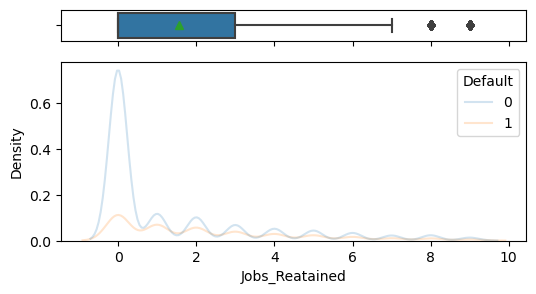

In [348]:
histbox(df['Jobs_Reatained'][df['Jobs_Reatained']<10], hue='Default')

#### Names of business with >2000 reatained jobs

In [295]:
for name in df[df.Jobs_Reatained>2000]['Borrower_Name'].sort_values():
    print(name)

1889 TERRITORIAL RESTAURANT
ABLE TOOL CORP. & R. HAYES
AGGREGATE TRANSPORT CORP.
AIR KING SUPPLY
ALPHA CONTAINER CORP
ANCHOR OFFSET PREP INC
APPLIED CHEMICAL TECHNOLOGY, I
ASSOCIATED METAL PRODUCTS INC
AURORA MALL CONOCO
AUTOBRITE - BROADWAY
BEAR PAW PRODUCTS INC
BEEROD IMPORTS
BONHARDS NURSERY, INC.
BRADSHAW'S RESTAURANT
BRITE IDEAS
BROTHERS INDUSTRIAL CLEANING
BUD'S TV AND SATELLITE / M & L
BURGER BOX #17
BURNET MACHINE & TOOL
BUTCHER BOY GROCERY
CAAMS, INC.
CENTRAL IL BOOKBINDING, INC
CENTURY LANES INC.
CINCINNATI CASING CO., INC.
CONTINENTAL OILFIELD SUPPLY IN
CRAIG'S CLEANERS, INC.
CUSTOM CABINETS BY DANTE, LTD.
DARLA & MICHAEL EBENROTH
DENTAL EYE CARE ASSOCIATES
DOC HONEST, INC.
DUDS 'N SUDS CORPORATION
EAGLE FENCE AND SUPPLY INC AND
EL POLLO GOLLO, BURRITO KING
FISCHER INDUSTRIAL COATINGS IN
FORTY EIGHT HUNDRED PAYNE AVE.
FOUR LEAF INDUSTRIES, INC
FOUR SEASONS DEPT. STORE
FRANK D. EAVES
FRASER SALES,INC
G & C UTILITIES, INC.
GRANNYS PEPPERMINT PALACE
HISTORIC SALEM
HM GRAPHICS I

#### Same borrower name can make different loans in different cities, amounts, term, from different bank etc

In [296]:
df[df['Borrower_Name']=='SUBWAY']

Business  Jobs_Reatained  Jobs_Created  Count_Employees  \
1402         New               9             0                8   
2909    Existing               0             0               11   
3269         New               0            14                1   
3567         New               0             0                1   
5026         New               0             0                3   
...          ...             ...           ...              ...   
101226  Existing               0             0                9   
101753  Existing              10             0                9   
102884       New               0             0                1   
103855  Existing               0             0                3   
104743       New               1             6                1   

        Classification_Code  Code_Franchise Demography  Loan_Term  \
1402                 722211           78760      Urban        180   
2909                 722211           78760      Rural        126   
3269                 722211           78760      Urban        140   
3567                 711110           78760      Urban         64   
5026                 722211           78760      Rural        126   
...                     ...             ...        ...        ...   
101226               722110           78760      Urban        126   
101753               722110           78760      Urban        126   
102884                    0           78760  Undefined        360   
103855                    0           78760  Undefined        126   
104743               445299           78760      Urban        414   

        Guaranteed_Approved_Loan  Loan_Approved_Gross  Gross_Amount_Disbursed  \
1402                   9753600.0           13004800.0             13004800.00   
2909                   7668768.0            9022080.0              9022080.00   
3269                   8636000.0           10160000.0             10160000.00   
3567                   9509760.0           12679680.0             12679680.00   
5026                   7530592.0            8859520.0              8859520.00   
...                          ...                  ...                     ...   
101226                 3454400.0            4064000.0              4064000.00   
101753                 2438400.0            4876800.0              4876800.00   
102884                10869168.0           14492224.0             14378675.84   
103855                 3251200.0            4064000.0              4064000.00   
104743                24384000.0           32512000.0             32512000.00   

        Gross_Amount_Balance  ChargedOff_Amount Low_Documentation_Loan  \
1402                     0.0               0.00                     No   
2909                     0.0               0.00                    Yes   
3269                     0.0               0.00                     No   
3567                     0.0         9307941.76                     No   
5026                     0.0               0.00                    Yes   
...                      ...                ...                    ...   
101226                   0.0               0.00                    Yes   
101753                   0.0               0.00                     No   
102884                   0.0               0.00                     No   
103855                   0.0               0.00                    Yes   
104743                   0.0               0.00                     No   

       Revolving_Credit_Line Year_Of_Commitment Borrower_Name Borrower_City  \
1402                       0               2007        SUBWAY  Mahendragarh   
2909                       0               2004        SUBWAY      Rupnagar   
3269                       0               2002        SUBWAY    Vedaranyam   
3567                      No               2002        SUBWAY      Baramula   
5026                       0               2003        SUBWAY    Shikohabad   
...                      ...          

### Jobs_Created 
What is that 2000+

Non-zero values: 32712 (31.15% of total non null), null: 0
Upper whisker: 2.5, amount: 17393
Lower whisker: -1.5, amount: 0


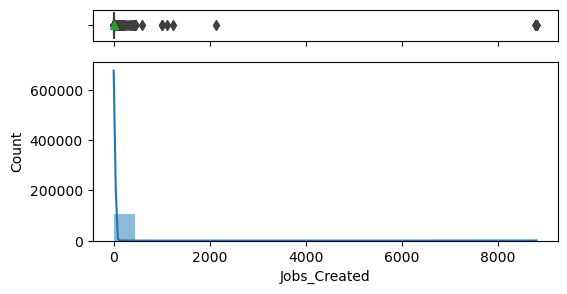

In [286]:
histbox('Jobs_Created')

Non-zero values: 4654 (100.0% of total non null), null: 0
Upper whisker: 52.5, amount: 386
Lower whisker: -7.5, amount: 0


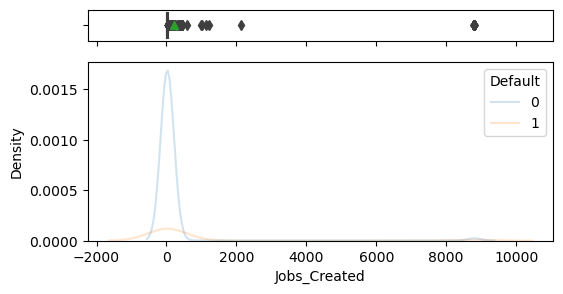

In [352]:
histbox(df['Jobs_Created'][df['Jobs_Created']>10], hue='Default')

In [299]:
df[df['Jobs_Created']>8000]

Business  Jobs_Reatained  Jobs_Created  Count_Employees  \
652          New            8800          8800                9   
1230    Existing            8800          8800               12   
2301    Existing            8800          8800                5   
2850         New            8800          8800                3   
3507    Existing            8800          8800                3   
...          ...             ...           ...              ...   
97969        New            8800          8800                7   
98700   Existing            8800          8800                3   
100915  Existing            8800          8800               69   
102825  Existing            8800          8800                6   
103773  Existing            8800          8800                2   

        Classification_Code  Code_Franchise Demography  Loan_Term  \
652                       0               0  Undefined        126   
1230                      0               0  Undefined        360   
2301                      0           58517  Undefined         42   
2850                      0               0  Undefined          9   
3507                      0               0  Undefined         38   
...                     ...             ...        ...        ...   
97969                     0               0  Undefined        146   
98700                     0               0  Undefined         58   
100915                    0               0  Undefined        360   
102825                    0               0  Undefined        360   
103773                    0               0  Undefined        123   

        Guaranteed_Approved_Loan  Loan_Approved_Gross  Gross_Amount_Disbursed  \
652                    4675632.0            5283200.0               5283200.0   
1230                  16418560.0           16418560.0              16418560.0   
2301                   5388864.0            6339840.0               6339840.0   
2850                   3495040.0            4064000.0               4064000.0   
3507                   3657600.0            4064000.0               4064000.0   
...                          ...                  ...                     ...   
97969                  5266944.0            5852160.0               5852160.0   
98700                  4535424.0            5039360.0               5039360.0   
100915                40640000.0           40640000.0              40640000.0   
102825                 8046720.0            8046720.0               7884160.0   
103773                 4389120.0            4876800.0               4876800.0   

        Gross_Amount_Balance  ChargedOff_Amount Low_Documentation_Loan  \
652                      0.0         5099100.80                     No   
1230                     0.0               0.00                     No   
2301                     0.0         1911217.92                     No   
2850                     0.0         3341014.40                     No   
3507                     0.0         2698496.00                     No   
...                      ...                ...                    ...   
97969                    0.0          629351.04                     No   
98700                    0.0         2973953.92                     No   
100915                   0.0               0.00                     No   
102825                   0.0               0.00                     No   
103773                   0.0          909198.08                     No   

       Revolving_Credit_Line Year_Of_Commitment  \
652                       No               1986   
1230                      No               1986   
2301                      No               1986   
2850                      No               1986   
3507                      No               1986   
...                      ...                ...   
97969                     No               1986   
98700                     No               1986   
100915                    No               1986   
10

### Count_Employees
Borrower_Name 1000+

Non-zero values: 104148 (99.19% of total non null), null: 0
Upper whisker: 19.5, amount: 11187
Lower whisker: -8.5, amount: 0


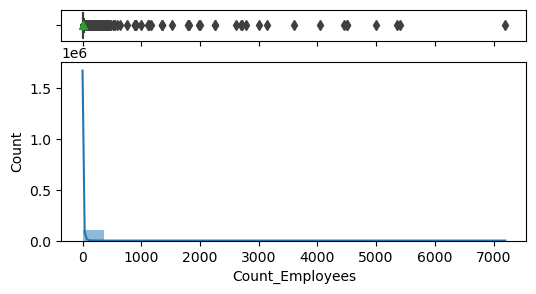

In [287]:
histbox('Count_Employees')

Non-zero values: 92961 (99.09% of total non null), null: 0
Upper whisker: 12.0, amount: 8131
Lower whisker: -4.0, amount: 0


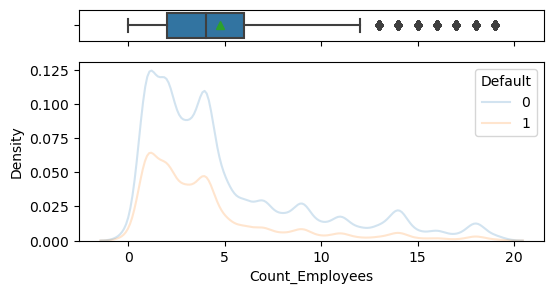

In [355]:
histbox(df['Count_Employees'][df['Count_Employees']<20], hue='Default')

Non-zero values: 10597 (100.0% of total non null), null: 0
Upper whisker: 87.5, amount: 967
Lower whisker: -12.5, amount: 0


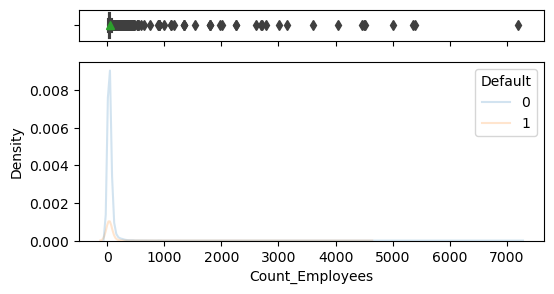

In [356]:
histbox(df['Count_Employees'][df['Count_Employees']>20], hue='Default')

### Code_Franchise
- Not sure what to do with franchise code yet.
- There are only 5962 of loan with code franchise =/= 1 or 0
- There's 1212 unique code, only 666 of unique code appear 2 times or more
- list of franchise code that is not 1 and 0, and appear 2 times or more: **franchise_code_2**

**Conclusion:**
- Be in a franchise is less likely to default
- Cat: 0,1 or odd of 0,1, others

Non-zero values: 77836 (74.13% of total non null), null: 0
Upper whisker: 2.5, amount: 5962
Lower whisker: -1.5, amount: 0


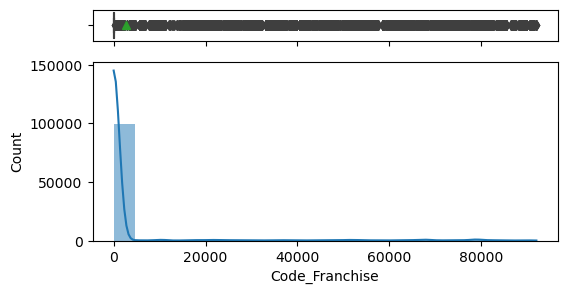

In [288]:
histbox('Code_Franchise')

#### Dig deeper

In [362]:
df[['Code_Franchise','Borrower_Name']][df['Code_Franchise']>2].sort_values('Code_Franchise').head(100)

Code_Franchise                   Borrower_Name
88126             399  1-800 DRY CLEAN OF SCRIPPS POW
78715             399                  1-800 DRYCLEAN
70823             399        PETERMAN ENTERPRISES INC
53852             400                      1 POTATO 2
72177             401                 SecondWind, LLC
...               ...                             ...
34949            1560           Ace Hardware Carlsbad
54178            1560  KOKOMO ACE HARDWARE & GARDEN C
34749            1570                    HENRY'S ACME
68266            2105          PERFECT MATCH, INC., A
71317            2105                    AERO COLOURS

[100 rows x 2 columns]

<AxesSubplot:>

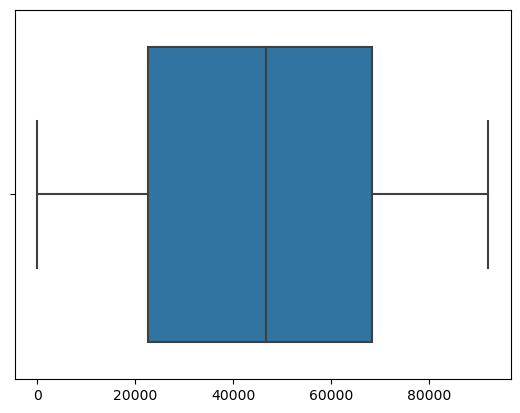

In [364]:
sns.boxplot(df['Code_Franchise'].unique())

Name is slightly different but looks like the same categories

In [366]:
df[['Code_Franchise','Borrower_Name']][df.Code_Franchise==1560]

Code_Franchise                   Borrower_Name
2772             1560            LINCOLN ACE HARDWARE
6611             1560             BOISE HARDWARE,INC.
10546            1560           KIRKWOOD ACE HARDWARE
15106            1560                    ACE HARDWARE
15289            1560  SPIRO ACE HARDWARE & FURNITURE
15607            1560       Ace Hardware at Westwoods
27423            1560      ACE HARDWARE OF BRIDGEMILL
30127            1560    IDAHO INDUSTRIAL SALES, INC.
30364            1560              DOWNING'S HARDWARE
33003            1560             Ace Family Hardware
33795            1560  ELKVIEW ACE HARDWARE & BUILDIN
33825            1560  ACE HARDWARE HOME & GARDEN CTR
34396            1560           FRONTIER ACE HARDWARE
34949            1560           Ace Hardware Carlsbad
35597            1560                    Ace Hardware
37881            1560  NORTHEASTERN INVESTMENTS, INC.
44044            1560      GARLAND C & S ACE HARDWARE
49195            1560      ACE HARDWARE OF WASHINGTON
54178            1560  KOKOMO ACE HARDWARE & GARDEN C
58837            1560       MARTINSVILLE ACE HARDWARE
61641            1560           MCCABE'S ACE HARDWARE
62005            1560     LEE VISTA ACE HARDWARE, INC
62546            1560  CANADIAN LAKES ACE HARDWARE LL
62564            1560  ACE HARDWARE AND GEORGETOWN DI
62899            1560   ACE HARDWARE OF BRISTOL, INC.
63148            1560              K & R ACE HARDWARE
64783            1560  ATASCOCITA ACE HARDWARE CENTER
73092            1560  FELTON'S WAREHOUSE BUILDING CE
77385            1560    ACE LUMBER & BUILDING SUPPLY
84847            1560             ACE HARDWARE DALTON
86318            1560          KARSTEN'S ACE HARDWARE
93964            1560           Hayman Hardware, L.C.
96806            1560          Ace Wellesley Hardware

In [370]:
df[['Code_Franchise','Borrower_Name']][df.Code_Franchise==2105]

Code_Franchise           Borrower_Name
61971            2105   DHX ENTERPRISES, INC.
62090            2105  LJB & ASSOCIATES, INC.
68266            2105  PERFECT MATCH, INC., A
71317            2105            AERO COLOURS

**How many unique code franchise that appear more than 1?**

>=2: 666
>=10: 126
>=20: 52
>=50: 13

In [400]:
len(df.Code_Franchise.unique())

1212

In [398]:
df.Code_Franchise.value_counts()[df.Code_Franchise.value_counts()>=0]

1        71874
0        27164
78760      394
68020      216
50564      113
         ...  
19118        1
44066        1
50039        1
76710        1
34652        1
Name: Code_Franchise, Length: 1212, dtype: int64

In [396]:
df[['Code_Franchise','Borrower_Name']][df.Code_Franchise==0].head(50)

Code_Franchise                   Borrower_Name
3                 0  K & A AUTOMOTIVE, INC. DBA MUF
6                 0          Diffusion Limited, LLC
8                 0             J & K Fitness, Inc.
12                0  J.D. Floorworks, Inc. dba Floo
13                0                2201 Shore, Inc.
15                0  COMMERCIAL SERVICES EXPRESS, I
17                0                   Le Bouder LLC
18                0          Advance Industries Inc
20                0  Sap-Sap, LLC dba East West Gri
25                0         Hi Rise Amenities, Inc.
26                0               B&A HOLDINGS, LLC
28                0       EPIC BIKE AND SPORT, INC.
29                0    COUNTRYSIDE CRAFT MALL, INC.
35                0  The Upper Room Embroidery Shop
41                0         Jazfam Associates, Inc.
46                0              Welroc Pizza, Inc.
47                0             Matthew N. MaCaulay
49                0              Pay Less Insurance
50                0  Spotted Cow Ice Cream and Coff
52                0          V & R Of Orlando, Inc.
57                0              Koffee Klutch,Inc.
59                0          CLEAR INVESTMENTS, LLC
61                0                  BRIAN T VILORD
64                0           Blue Bottle Cafe, LLC
65                0                JLB Online, Inc.
71                0           B.W. CONTRACTORS, LLC
75                0  HEALTH 1ST OF GREENFIELD, P.C.
76                0                KID CITY ACADEMY
77                0       New Country Cleaners, LLC
78                0              CAKE SERA SERA INC
79                0  KIL JONG KO DBA ACE POOL MAINT
81                0          RICHARD & SANDRA MOORE
94                0       Raul Jimenez Construction
100               0  A & W Enterprises of Chicago C
101               0  Sangalis Financial Group, Inco
106               0     GREAT DEALS ON WHEELS, INC.
113               0               Vedic Group, Inc.
122               0  Sandra N Heinman DBA Sandy's N
123               0          MCDental Care P.L.L.C.
125               0            GRAF'S POPCORN WAGON
128               0  P & Pi International Investmen
134               0        INDOOR FUN 'N' MORE INC.
137               0            ALTAIR HOLDINGS, LLC
139               0            J & K TRUCKING, INC.
140               0       Siegman Investments, Inc.
141               0     Pyramid Food Services Corp.
144               0            Monterrey Washateria
147               0  Blank Canvas Construction, LLC
148               0         LINDA'S USED APPLIANCES
150               0            Phantoms Corporation

In [401]:
df.Code_Franchise[df.Code_Franchise>1].shape

(5962,)

In [405]:
# list of franchise code that is not 1 and 0, and appear 2 times or more
franchise_code_2 = df.Code_Franchise.value_counts()[df.Code_Franchise.value_counts()>=2].index

Non-zero values: 103609 (99.19% of total non null), null: 0
Upper whisker: 19.5, amount: 11111
Lower whisker: -8.5, amount: 0


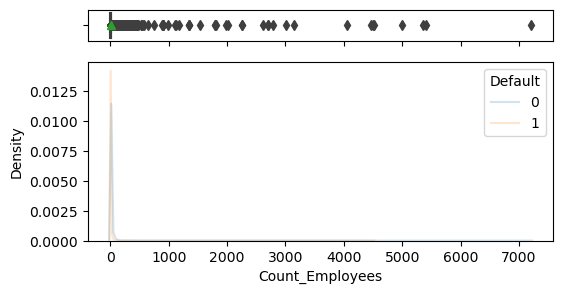

In [406]:
histbox(df['Count_Employees'][df['Code_Franchise'].isin(franchise_code_2)], hue='Default')

#### See odd
- Be in a franchise is less likely to default
- Cat: 0,1 or odd of 0,1, others

In [249]:
where_list = [df['Code_Franchise']==0,df['Code_Franchise']==1,df['Code_Franchise']>1]

for where,name in zip(where_list,['is 0','is 1','others']):
    print(name,':', where.sum())
    print(df.Default[where].value_counts(normalize=True))
    print('*'*50)

is 0 : 27164
0    0.516014
1    0.483986
Name: Default, dtype: float64
**************************************************
is 1 : 71874
0    0.798119
1    0.201881
Name: Default, dtype: float64
**************************************************
others : 5962
0    0.757296
1    0.242704
Name: Default, dtype: float64
**************************************************


### Loan_Term
Default is more on the lower end, because shorter term leads to easier default? Not enough time to pay

Non-zero values: 104850 (99.86% of total non null), null: 0
Upper whisker: 315.0, amount: 16600
Lower whisker: -45.0, amount: 0


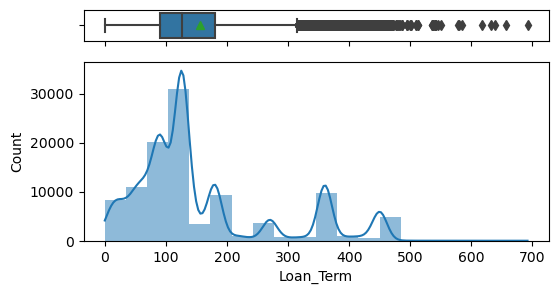

In [289]:
histbox('Loan_Term')

Non-zero values: 16904 (100.0% of total non null), null: 0
Upper whisker: 585.0, amount: 5
Lower whisker: 225.0, amount: 0


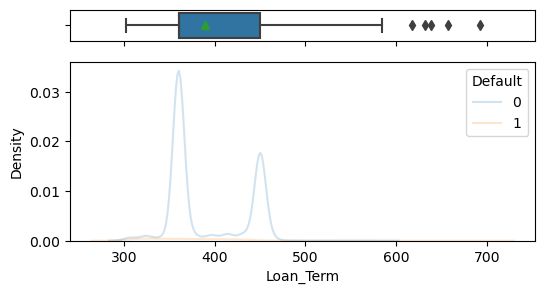

In [408]:
histbox(df.Loan_Term[df.Loan_Term>300], hue='Default')

Non-zero values: 87930 (99.83% of total non null), null: 0
Upper whisker: 202.5, amount: 5015
Lower whisker: -1.5, amount: 0


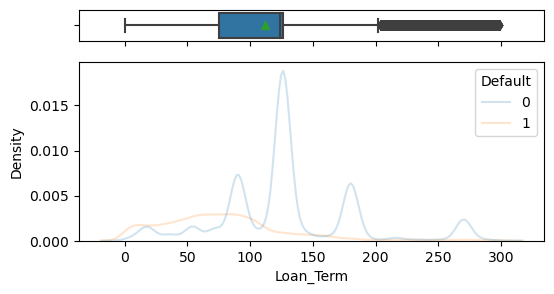

In [412]:
histbox(df.Loan_Term[df.Loan_Term<300], hue='Default')

### Overview category----------------
- Not much here to go on yet
- Class 4 and Class 5 seems riskier than the others, **can class be transformed to odd**?
- Come back later if needed

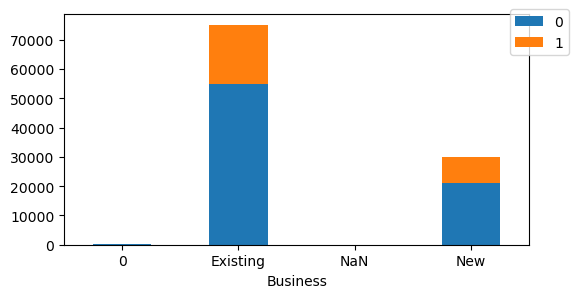

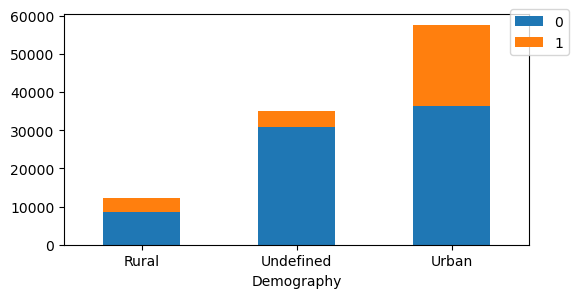

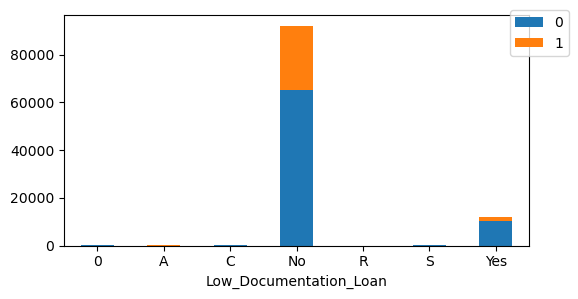

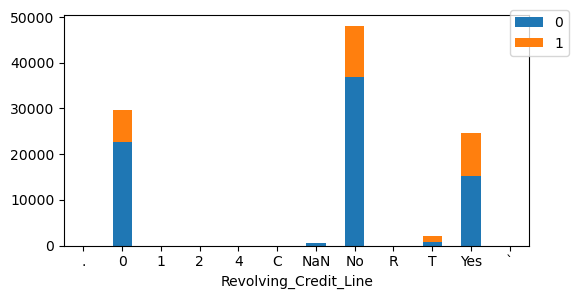

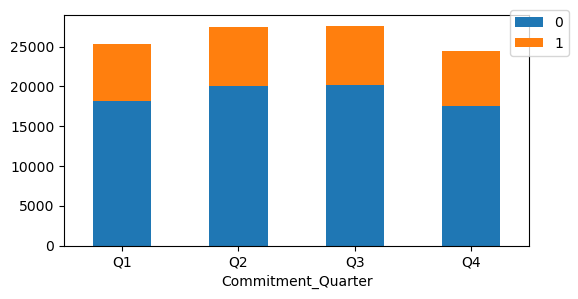

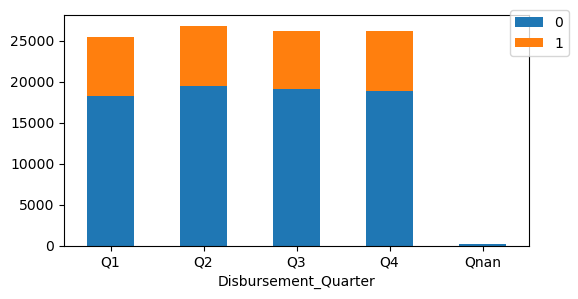

In [25]:
# cat_cols = df.select_dtypes(include=object).columns
cat_cols = ['Business', 'Demography', 'Low_Documentation_Loan','Revolving_Credit_Line','Commitment_Quarter', 'Disbursement_Quarter']
for feature in cat_cols:
    stacked(feature)

### Business
- NaN = Existing, 0 = others
- To odd

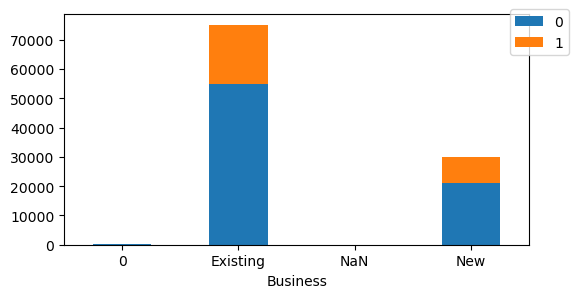

In [132]:
stacked(df['Business'])

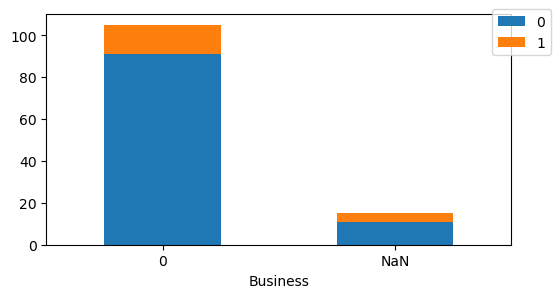

In [136]:
stacked(df['Business'][~df['Business'].isin(['Existing','New'])])

In [141]:
df.Business.value_counts()

Existing    75091
New         29789
0             105
NaN            15
Name: Business, dtype: int64

In [263]:
for business in df['Business'].unique():
    print(business)
    print((df.Business==business).sum())
    print(df['Default'][df.Business==business].value_counts(normalize=True, dropna=False))
    print('*'*50)

Existing
75091
0    0.728756
1    0.271244
Name: Default, dtype: float64
**************************************************
New
29789
0    0.707342
1    0.292658
Name: Default, dtype: float64
**************************************************
0
105
0    0.866667
1    0.133333
Name: Default, dtype: float64
**************************************************
NaN
15
0    0.733333
1    0.266667
Name: Default, dtype: float64
**************************************************


### Classification group
- Keep classfication
- To odds?

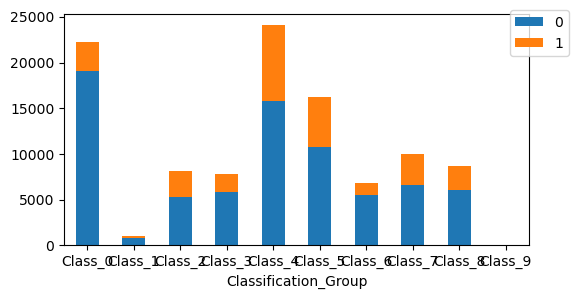

In [39]:
stacked(df['Classification_Group'])

### Low_Documentation_Loan
- NaN = A
- To odds before merge
- Merge: (0,C,Yes) , (No), Other(NaN, S, A, R)

In [258]:
df.Low_Documentation_Loan.fillna('NaN', inplace=True)

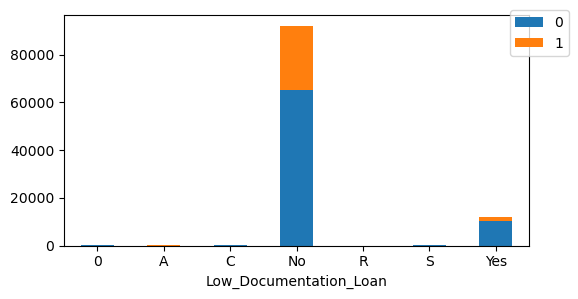

In [120]:
stacked(df.Low_Documentation_Loan)

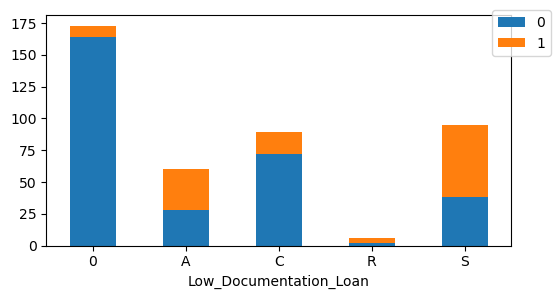

In [119]:
stacked(df.Low_Documentation_Loan[~df.Low_Documentation_Loan.isin(['No','Yes'])])

In [125]:
df['Default'][df.Low_Documentation_Loan=='Yes'].value_counts(normalize=True, dropna=True)

0    0.850683
1    0.149317
Name: Default, dtype: float64

In [126]:
df['Default'][df.Low_Documentation_Loan=='C'].value_counts(normalize=True, dropna=True)

0    0.808989
1    0.191011
Name: Default, dtype: float64

In [260]:
for low_doc in df.Low_Documentation_Loan.unique():
    print(low_doc)
    print((df.Low_Documentation_Loan==low_doc).sum())
    print(df['Default'][df.Low_Documentation_Loan==low_doc].value_counts(normalize=True, dropna=False))
    print('*'*50)

No
92135
0    0.707104
1    0.292896
Name: Default, dtype: float64
**************************************************
Yes
12075
0    0.850683
1    0.149317
Name: Default, dtype: float64
**************************************************
NaN
367
1    0.53406
0    0.46594
Name: Default, dtype: float64
**************************************************
S
95
1    0.6
0    0.4
Name: Default, dtype: float64
**************************************************
0
173
0    0.947977
1    0.052023
Name: Default, dtype: float64
**************************************************
A
60
1    0.533333
0    0.466667
Name: Default, dtype: float64
**************************************************
C
89
0    0.808989
1    0.191011
Name: Default, dtype: float64
**************************************************
R
6
1    0.666667
0    0.333333
Name: Default, dtype: float64
**************************************************


In [124]:
df.Low_Documentation_Loan.unique()

array(['No', 'Yes', nan, 'S', '0', 'A', 'C', 'R'], dtype=object)

### Name of bank
- 143 unique banks
- Odds by bank? => yes

In [226]:
sorted(df.Name_Of_Bank.unique())

['AB Bank Ltd.',
 'Abu Dhabi Commercial Bank Ltd.',
 'Airtel Payments Bank Ltd',
 'American Express Banking Corp.',
 'Andhra Pradesh Grameena Vikas Bank',
 'Andhra Pragathi Grameena Bank',
 'Arunachal Pradesh Rural Bank',
 'Aryavart Bank',
 'Assam Gramin Vikash Bank',
 'Au Small Finance Bank Ltd.',
 'Australia and New Zealand Banking Group Ltd.',
 'Axis Bank Ltd.',
 'BNP Paribas',
 'Bandhan Bank Ltd.',
 'Bangiya Gramin Vikash Bank',
 'Bank of America',
 'Bank of Bahrain & Kuwait BSC',
 'Bank of Baroda',
 'Bank of Ceylon',
 'Bank of India',
 'Bank of Maharashtra',
 'Bank of Nova Scotia',
 'Barclays Bank Plc.',
 'Baroda Gujarat Gramin Bank',
 'Baroda Rajasthan Kshetriya Gramin Bank',
 'Baroda UP Bank',
 'CSB Bank Limited',
 'CTBC Bank Co., Ltd.',
 'Canara Bank',
 'Capital Small Finance Bank Ltd',
 'Central Bank of India',
 'Chaitanya Godavari GB',
 'Chhattisgarh Rajya Gramin Bank',
 'Citibank N.A.',
 'City Union Bank Ltd.',
 'Coastal Local Area Bank Ltd',
 'Cooperatieve Rabobank U.A.',
 

In [227]:
for bank in df.Name_Of_Bank.unique():
    print(bank)
    print((df.Name_Of_Bank==bank).sum())
    print(df.Default[df.Name_Of_Bank==bank].value_counts(normalize=True))
    print('*'*50)

Axis Bank Ltd.
423
0    0.820331
1    0.179669
Name: Default, dtype: float64
**************************************************
Bandhan Bank Ltd.
1161
0    0.711456
1    0.288544
Name: Default, dtype: float64
**************************************************
CSB Bank Limited
3530
0    0.708499
1    0.291501
Name: Default, dtype: float64
**************************************************
City Union Bank Ltd.
4541
0    0.674961
1    0.325039
Name: Default, dtype: float64
**************************************************
DCB Bank Ltd.
264
0    0.814394
1    0.185606
Name: Default, dtype: float64
**************************************************
Dhanlaxmi Bank Ltd.
7314
0    0.622231
1    0.377769
Name: Default, dtype: float64
**************************************************
Federal Bank Ltd.
323
0    0.839009
1    0.160991
Name: Default, dtype: float64
**************************************************
HDFC Bank Ltd
1300
0    0.822308
1    0.177692
Name: Default, dtype: float64
*****

### Borrower_Name
- 100000 unique name
- onle 2000 repeated name, which has 25% def
=> drop

In [229]:
len(df.Borrower_Name.unique())

101069

In [234]:
df.Borrower_Name.value_counts()[df.Borrower_Name.value_counts()>1].index

Index(['SUBWAY', 'QUIZNO'S SUBS', 'COLD STONE CREAMERY', 'MAIL BOXES ETC',
       'DOMINO'S PIZZA', 'DAIRY QUEEN', 'MATCO TOOLS', 'QUIZNO'S',
       'CURVES FOR WOMEN', 'GREAT CLIPS',
       ...
       'CULVERS', 'PETERS MACHINE INC', 'CERTIFIED TRANSPORTATION SERVI',
       'MICHIGAN PAVEMENT SOLUTIONS LL', 'GREEN DREAM INC', 'MOTORWORKS',
       'HOSCO, INC.', 'BURBANK AUTO ELECTRIC & MECHAN', 'COKER PRODUCTIONS',
       'MEYER CATTLE MARKETING INC'],
      dtype='object', length=2017)

In [237]:
df.Default[df.Borrower_Name.isin(df.Borrower_Name.value_counts()[df.Borrower_Name.value_counts()>1].index)].value_counts()

0    4514
1    1432
Name: Default, dtype: int64

### Borrower_State

In [261]:
for state in df.Borrower_State.unique():
    print(state)
    print((df.Borrower_State==state).sum())
    print(df.Default[df.Borrower_State==state].value_counts(normalize=True))
    print('*'*50)

Maharashtra
11699
0    0.716215
1    0.283785
Name: Default, dtype: float64
**************************************************
Delhi
359
0    0.779944
1    0.220056
Name: Default, dtype: float64
**************************************************
Karnataka
5672
0    0.739951
1    0.260049
Name: Default, dtype: float64
**************************************************
Gujarat
6386
0    0.724397
1    0.275603
Name: Default, dtype: float64
**************************************************
Telangana
3866
0    0.711071
1    0.288929
Name: Default, dtype: float64
**************************************************
Tamil Nadu
8805
0    0.727428
1    0.272572
Name: Default, dtype: float64
**************************************************
West Bengal
4709
0    0.721809
1    0.278191
Name: Default, dtype: float64
**************************************************
Rajasthan
5361
0    0.732886
1    0.267114
Name: Default, dtype: float64
**************************************************
Uttar Pra

### Revolving credit line
Combine:
- No and 0, R: same odd
- Yes (38.5, T, 41.4)
- The rest + Nan

If to odd: before merging the group

In [209]:
df.Revolving_Credit_Line.value_counts().index[:5]

Index(['No', '0', 'Yes', 'T', 'NaN'], dtype='object')

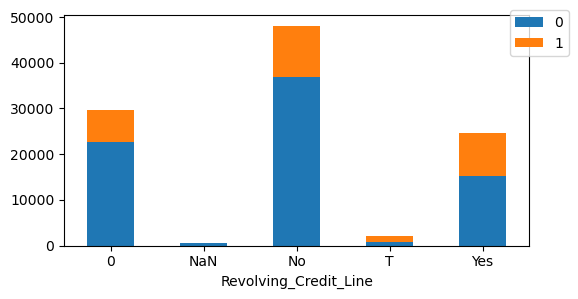

In [214]:
where = df.Revolving_Credit_Line.value_counts().index[:5]
stacked(df.Revolving_Credit_Line[df.Revolving_Credit_Line.isin(where)])

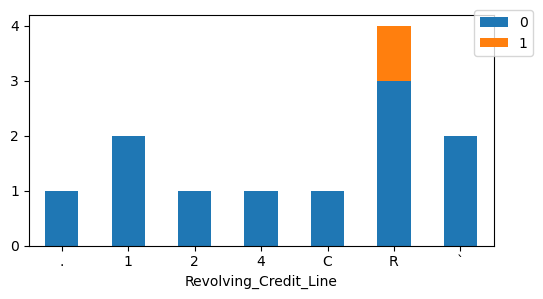

In [215]:
where = df.Revolving_Credit_Line.value_counts().index[:5]
stacked(df.Revolving_Credit_Line[~df.Revolving_Credit_Line.isin(where)])

In [218]:
for credit in df.Revolving_Credit_Line.unique():
    print(credit)
    print(df.Default[df.Revolving_Credit_Line==credit].value_counts(normalize=True))
    print('-'*50)

No
0    0.765346
1    0.234654
Name: Default, dtype: float64
--------------------------------------------------
0
0    0.761752
1    0.238248
Name: Default, dtype: float64
--------------------------------------------------
Yes
0    0.614698
1    0.385302
Name: Default, dtype: float64
--------------------------------------------------
T
1    0.585377
0    0.414623
Name: Default, dtype: float64
--------------------------------------------------
NaN
0    0.959267
1    0.040733
Name: Default, dtype: float64
--------------------------------------------------
R
0    0.75
1    0.25
Name: Default, dtype: float64
--------------------------------------------------
`
0    1.0
Name: Default, dtype: float64
--------------------------------------------------
2
0    1.0
Name: Default, dtype: float64
--------------------------------------------------
4
0    1.0
Name: Default, dtype: float64
--------------------------------------------------
.
0    1.0
Name: Default, dtype: float64
--------------------

Combine:
- No and 0, R: same odd
- Yes (38.5, T, 41.4)
- The rest + Nan

If to odd: before merging the group

## 3.2 Multivariate

### Heatmap
- Strong correlation between the loan amount columns, drop/transform 2 of which
- Longer the term, the bigger the loan amount, any meaningful way to transform this?
- Sum the jobs

In [33]:
 df.select_dtypes(include=np.number).columns

Index(['Jobs_Reatained', 'Jobs_Created', 'Count_Employees',
       'Classification_Code', 'Code_Franchise', 'Loan_Term',
       'Guaranteed_Approved_Loan', 'Loan_Approved_Gross',
       'Gross_Amount_Disbursed', 'Gross_Amount_Balance', 'ChargedOff_Amount',
       'Default', 'Commitment_Month', 'Commitment_Year', 'Disbursement_Month',
       'Disbursement_Year'],
      dtype='object')

<AxesSubplot:>

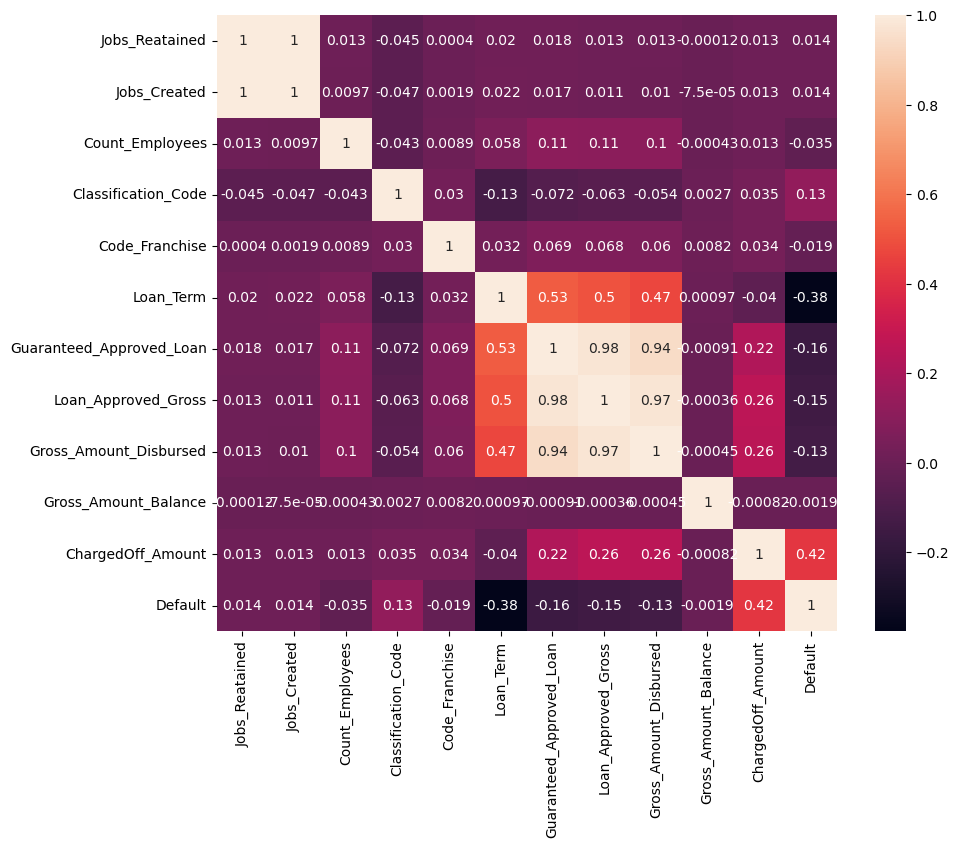

In [36]:
hm_cols = ['Jobs_Reatained', 'Jobs_Created', 'Count_Employees',
       'Classification_Code', 'Code_Franchise', 'Loan_Term',
       'Guaranteed_Approved_Loan', 'Loan_Approved_Gross',
       'Gross_Amount_Disbursed', 'Gross_Amount_Balance', 'ChargedOff_Amount',
       'Default']
plt.figure(figsize=(10,8))
sns.heatmap(df[hm_cols].corr(), annot=True)

### Pairplot
**Observation:**
- Outlier on loan term
- Gross disburse (tend to)> guarantee approved, also 3 lines
- Gross approve  (always)> guarantee approved, also 3 lines
- gross disburse, gross approve: there's only one line?
- The limit on all 3? (which goes above the limit?) also very few default go over the limit

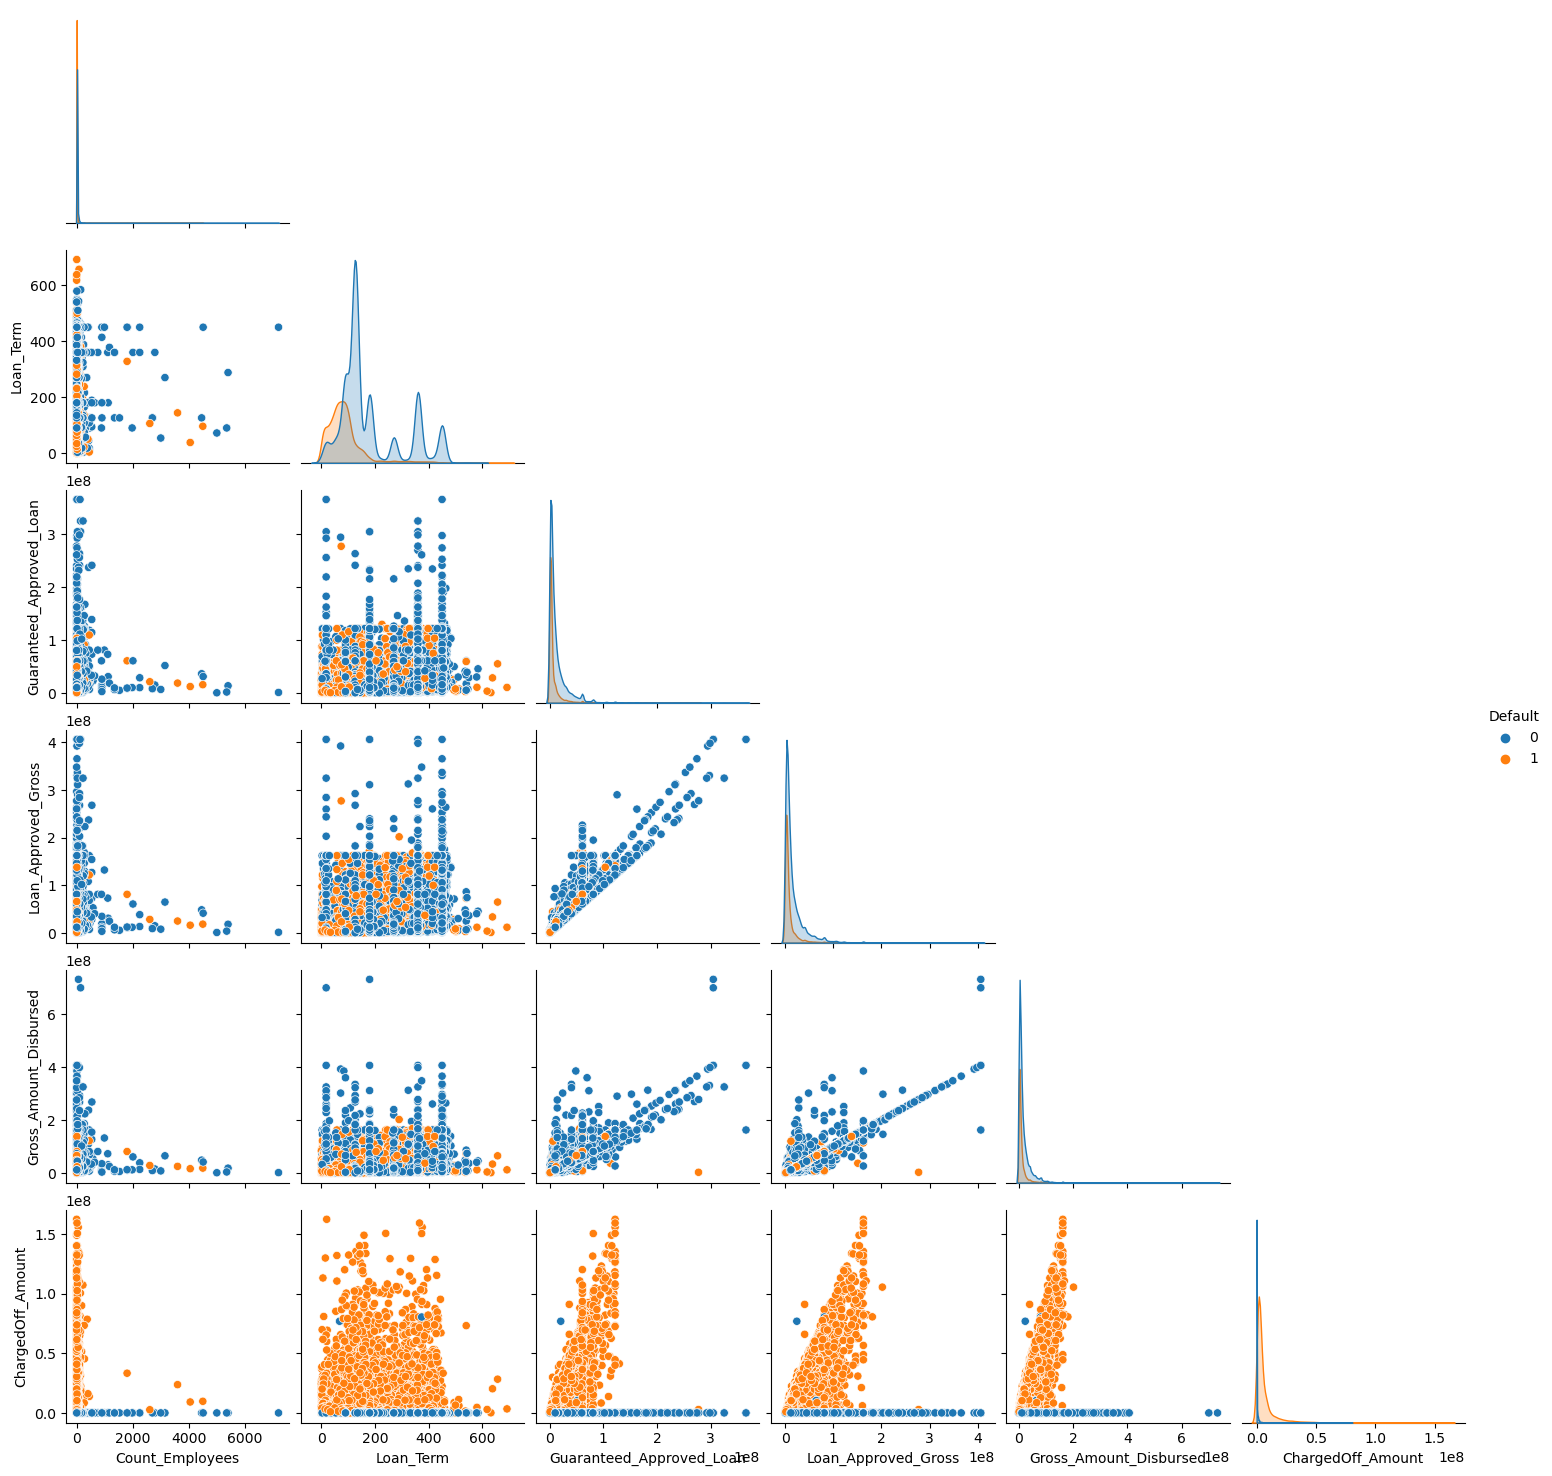

In [48]:
view_pairplot = ['Count_Employees', 'Loan_Term', 'Guaranteed_Approved_Loan', 'Loan_Approved_Gross',
       'Gross_Amount_Disbursed', 'ChargedOff_Amount','Default']
sns.pairplot(df[view_pairplot], hue='Default', corner = True)

**Without the extreme values**

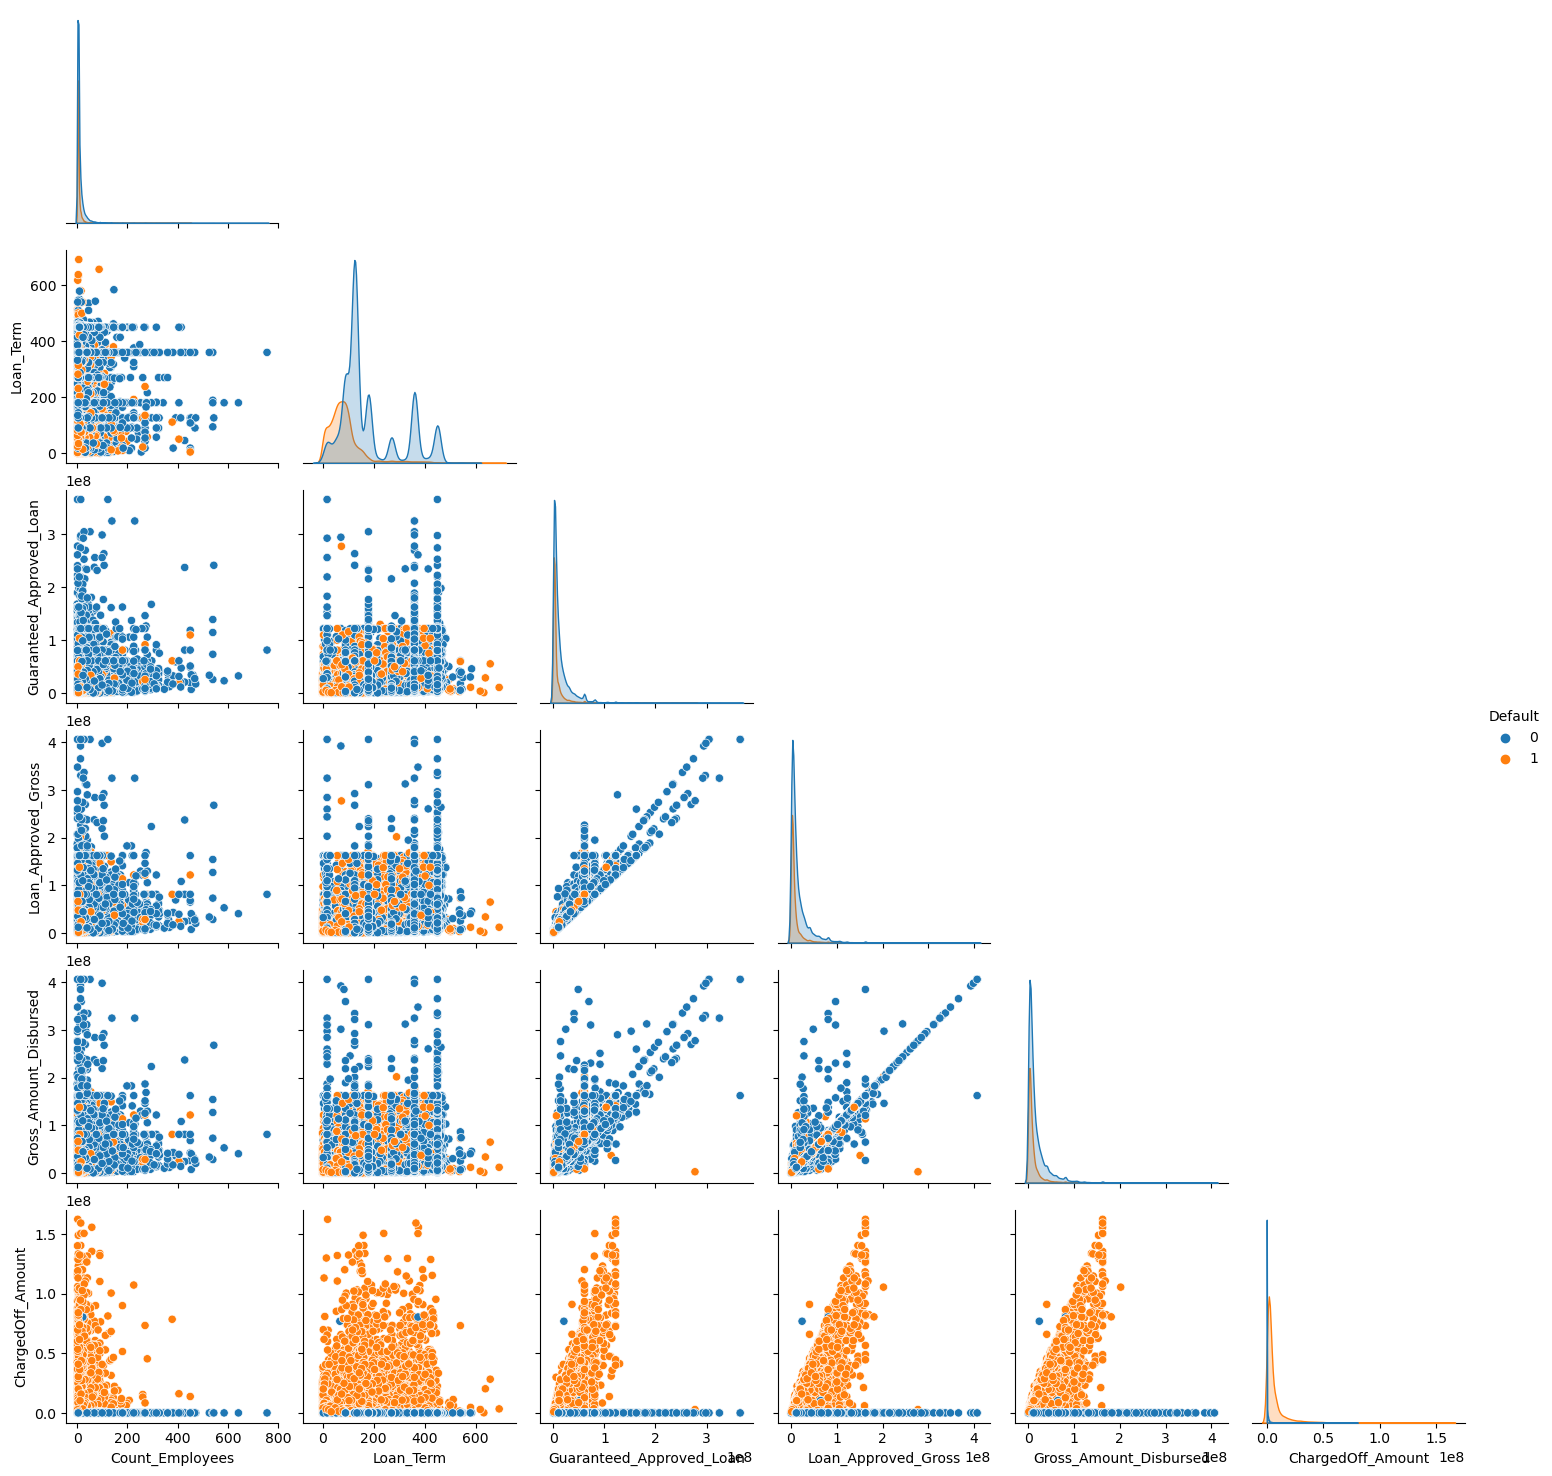

In [50]:
view_pairplot = ['Count_Employees', 'Loan_Term', 'Guaranteed_Approved', 'Gross_Approved',
       'Gross_Disbursed', 'ChargedOff_Amount','Default']
sns.pairplot(df[view_pairplot][(df['Count_Employees']<800) & (df['Gross_Disbursed']<6e8)] , hue='Default', corner = True)

**Observation:**
- Outlier on loan term
- Gross disburse (tend to)> guarantee approved, also 3 lines
- Gross approve  (always)> guarantee approved, also 3 lines
- gross disburse, gross approve: there's only one line?
- The limit on all 3? (which goes above the limit?) also very few default go over the limit

### The loan pairs
- Nothing conclusive yet. Come back later
- Keep one and create percent of others?
- plot the loan amount vs term, hue = category
- There's a cap for Gross_Disbursed at 1.6256e8 that only 150~ loan are larger than this
- Guaranteed_Approved < Gross_Approved < Gross_Disbursed
>- Guaranteed_Approved < Gross_Approved: always
>- Guaranteed_Approved < Gross_Disbursed: 98%
>- Gross_Approved < Gross_Disbursed: 95%

**Create both minus and percentage feature of this, option to drop the original**

#### pairs plot

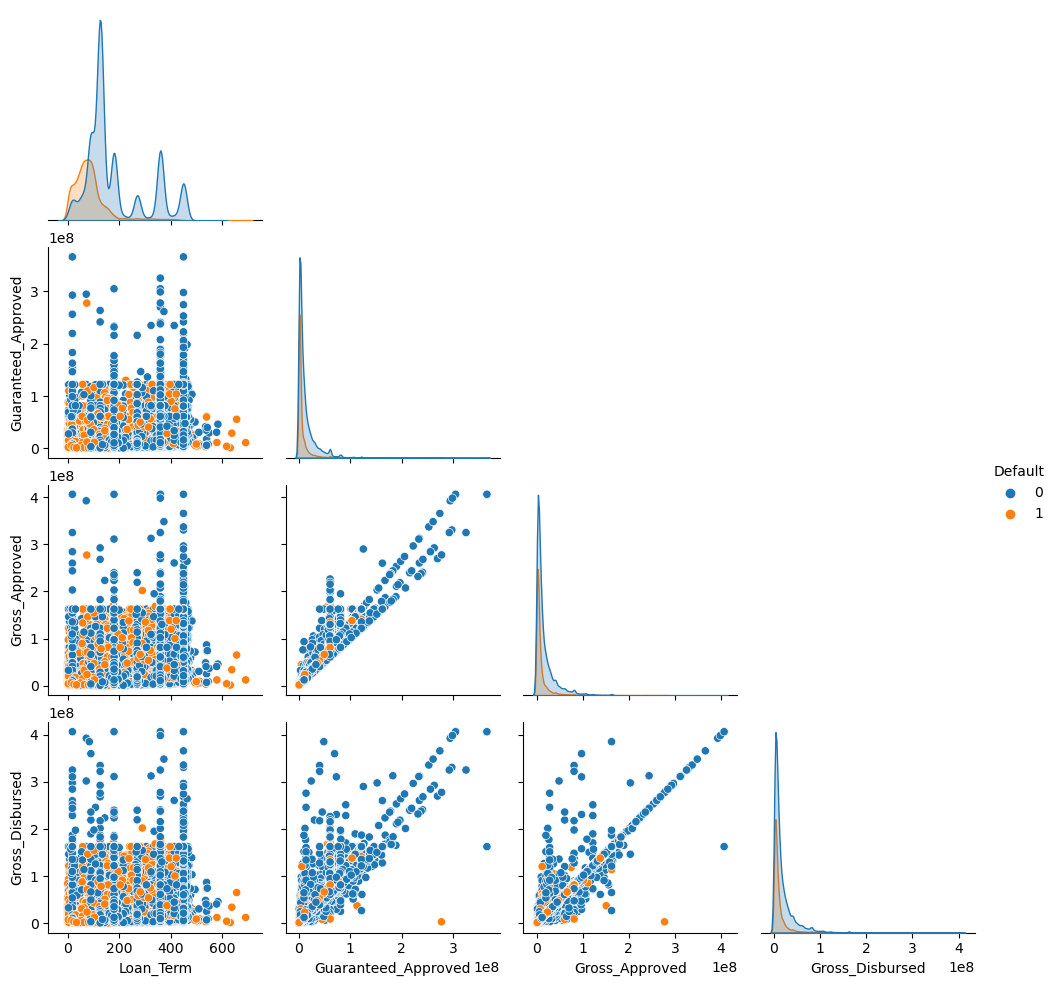

In [98]:
view_pairplot = ['Loan_Term', 'Guaranteed_Approved', 'Gross_Approved','Gross_Disbursed','Default']
sns.pairplot(df[view_pairplot][(df['Count_Employees']<800) & (df['Gross_Disbursed']<6e8)] , hue='Default', corner = True)

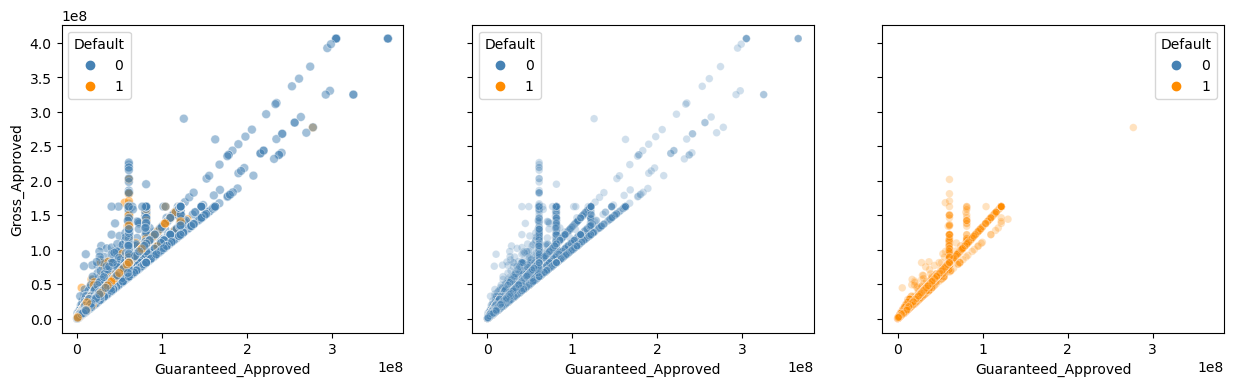

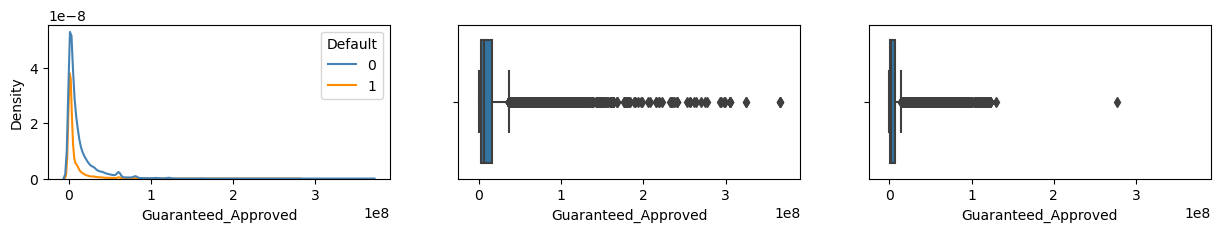

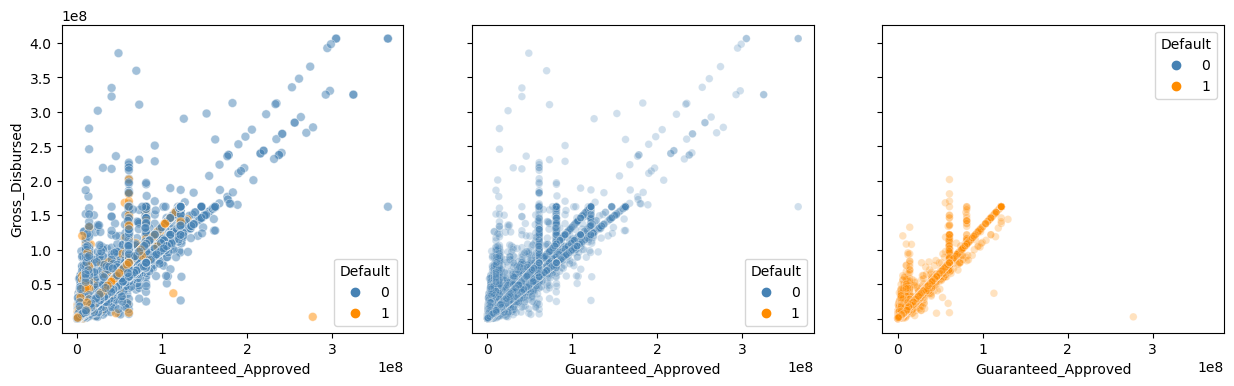

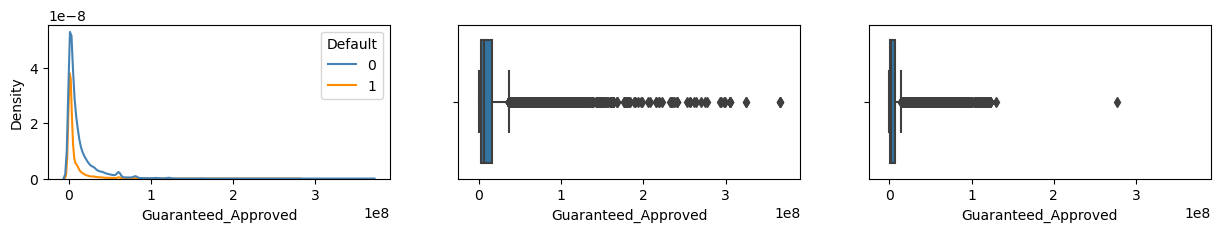

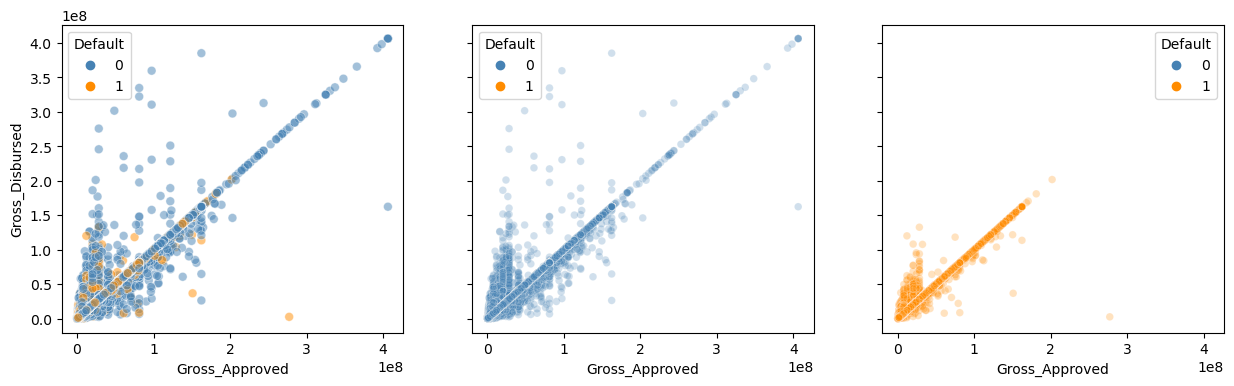

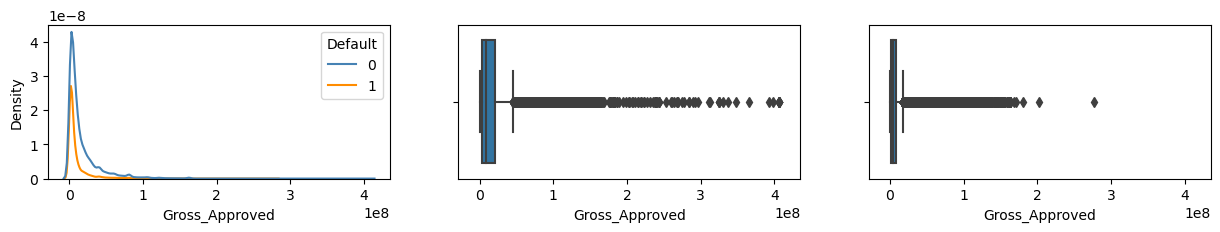

In [161]:
data_yx = [('Guaranteed_Approved', 'Gross_Approved'),
('Guaranteed_Approved', df['Gross_Disbursed'][df['Gross_Disbursed']<6e8]),
('Gross_Approved',df['Gross_Disbursed'][df['Gross_Disbursed']<6e8])]

for data_y, data_x in data_yx:
    make_scatter(data_y,data_x,'Default',kde=True, alpha=0.5)

**Where equals:**

In [85]:
df[df['Guaranteed_Approved'] == df['Gross_Approved']]['Default'].value_counts()

0    7286
1     159
Name: Default, dtype: int64

Non-zero values: 7445 (100.0% of total non null), null: 0
Upper whisker: 360.0, amount: 164
Lower whisker: 360.0, amount: 797


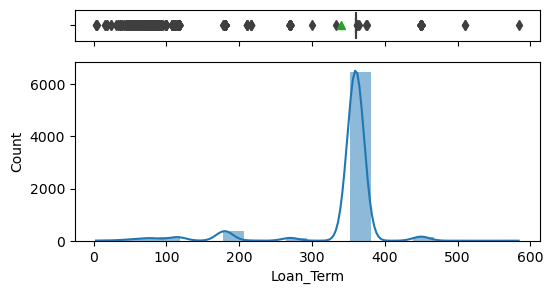

In [86]:
# Business, Demography, Loan_Term,
histbox(df['Loan_Term'][df['Guaranteed_Approved'] == df['Gross_Approved']])

In [87]:
df['Demography'][df['Guaranteed_Approved'] == df['Gross_Approved']].value_counts()

Undefined    3754
Urban        2710
Rural         981
Name: Demography, dtype: int64

#### see categorical

In [106]:
df.columns

Index(['Business', 'Jobs_Reatained', 'Jobs_Created', 'Count_Employees',
       'Classification_Code', 'Code_Franchise', 'Demography', 'Loan_Term',
       'Guaranteed_Approved', 'Gross_Approved', 'Gross_Disbursed',
       'Gross_Amount_Balance', 'ChargedOff_Amount', 'Low_Documentation_Loan',
       'Revolving_Credit_Line', 'Year_Of_Commitment', 'Borrower_Name',
       'Borrower_City', 'Borrower_State', 'Name_Of_Bank', 'State_Of_Bank',
       'Default', 'Classification_Group', 'Commitment_Month',
       'Commitment_Year', 'Disbursement_Month', 'Disbursement_Year',
       'Commitment_Quarter', 'Disbursement_Quarter'],
      dtype='object')

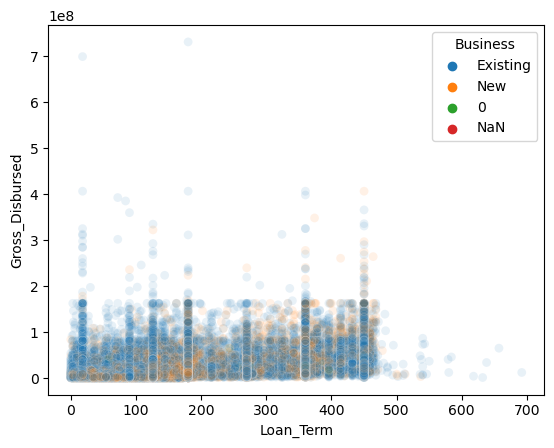

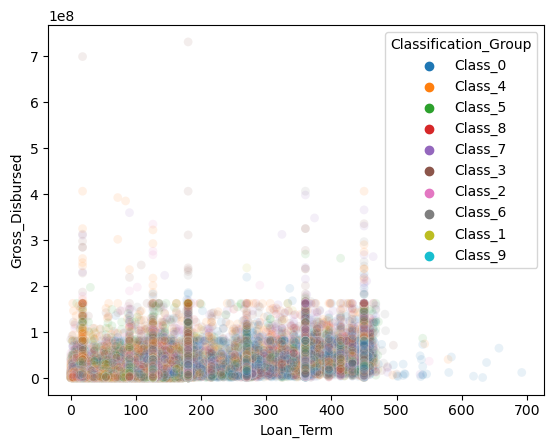

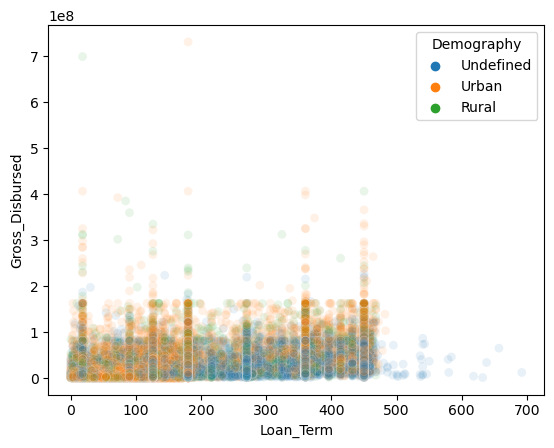

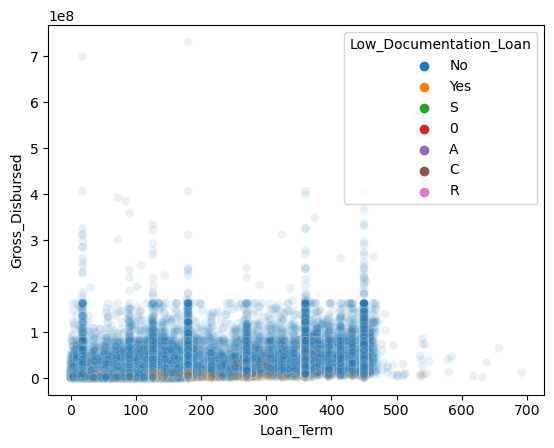

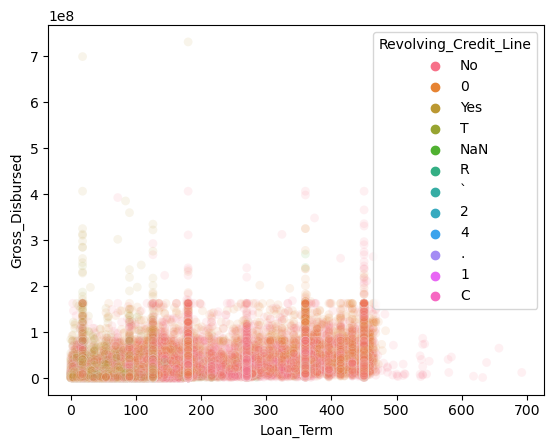

In [172]:
data_hue = ['Business', 'Classification_Group','Demography', 'Low_Documentation_Loan', 'Revolving_Credit_Line', ]
data_x = 'Loan_Term'
data_y = 'Gross_Disbursed'

for data_hue in data_hue:
    if type(data_x) == str:
        data_x = df[data_x]
    if type(data_y) == str:
        data_y = df[data_y]
    if type(data_hue) == str:
        data_hue = df[data_hue]
    sns.scatterplot(y=data_y, x = data_x, hue = data_hue, alpha = 0.1, s=40)
    plt.show()

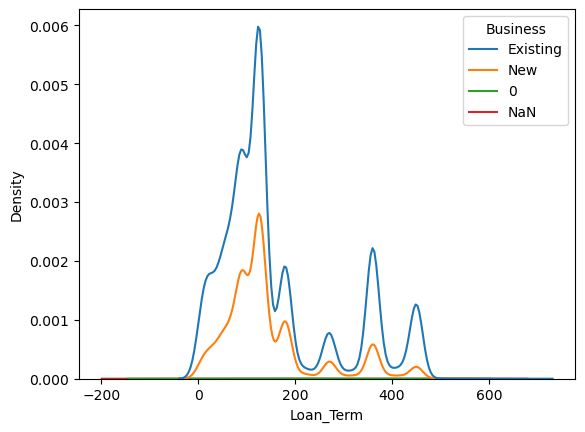

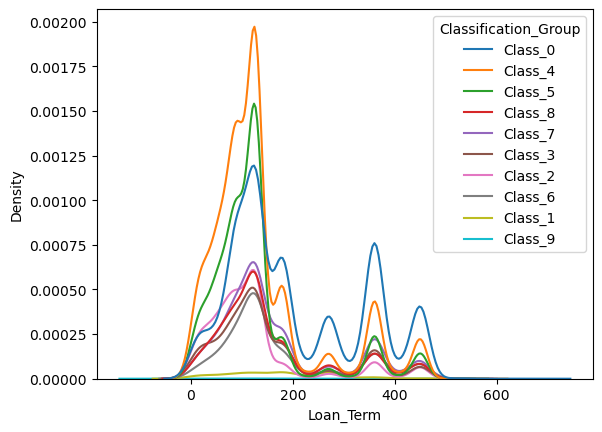

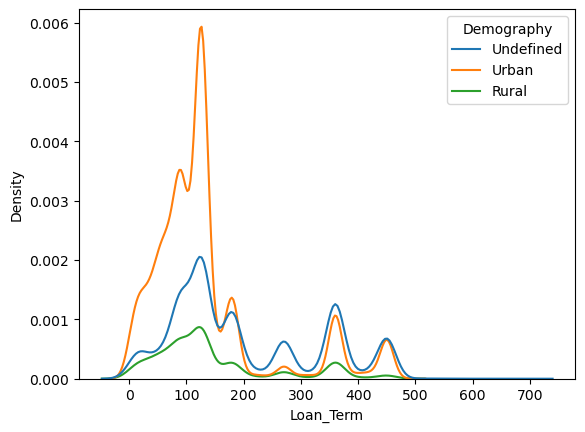

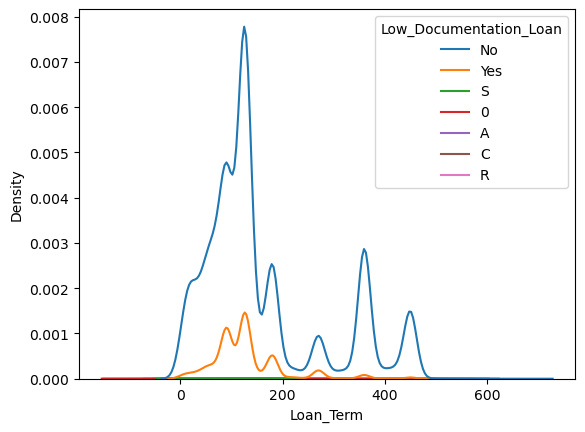

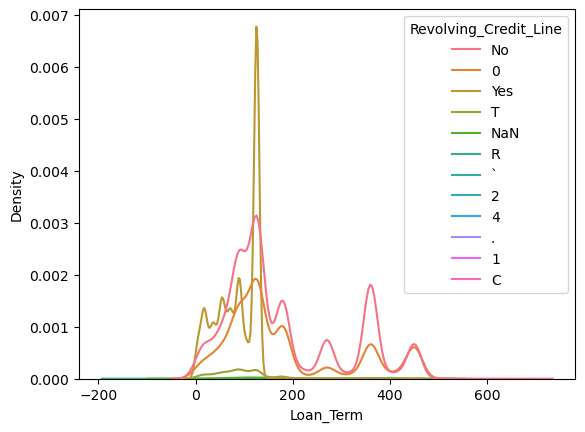

In [173]:
data_hue = ['Business', 'Classification_Group','Demography', 'Low_Documentation_Loan', 'Revolving_Credit_Line', ]
data_x = 'Loan_Term'
data_y = 'Gross_Disbursed'

for data_hue in data_hue:
    if type(data_x) == str:
        data_x = df[data_x]
    if type(data_y) == str:
        data_y = df[data_y]
    if type(data_hue) == str:
        data_hue = df[data_hue]
    sns.kdeplot(data_x, hue = data_hue)
    plt.show()

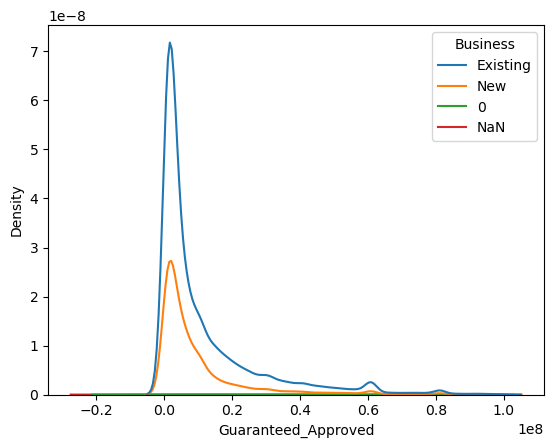

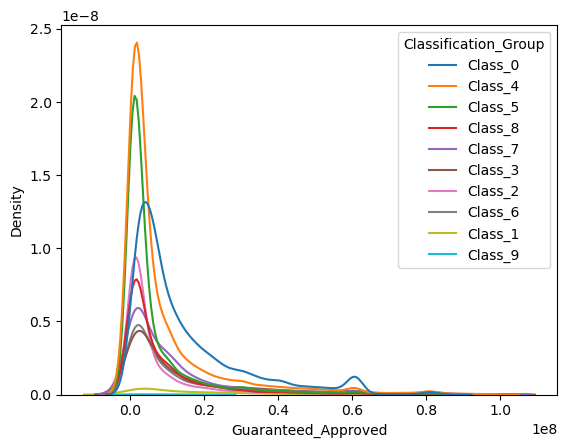

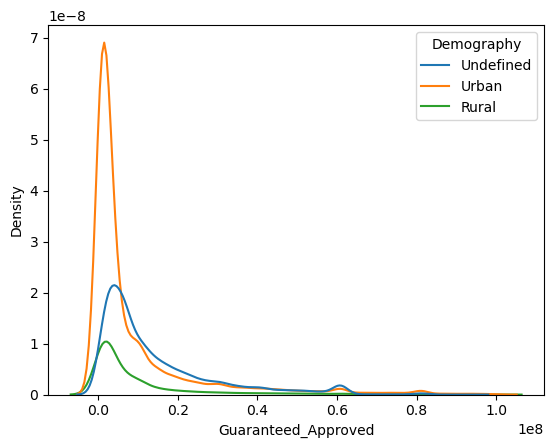

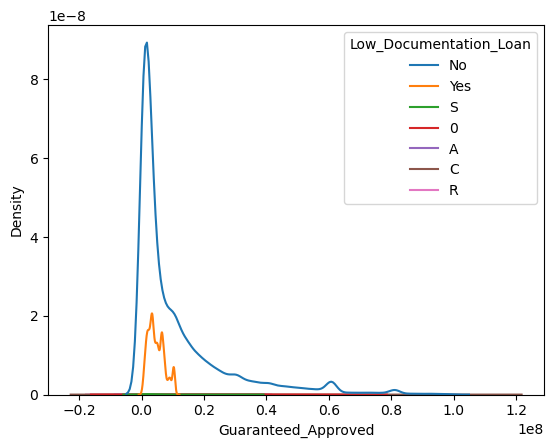

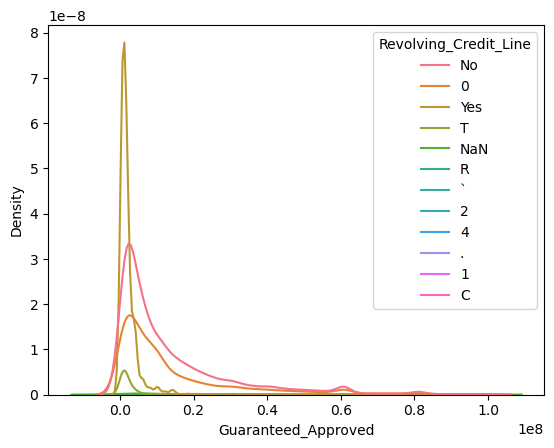

In [116]:
data_hue = ['Business', 'Classification_Group','Demography', 'Low_Documentation_Loan', 'Revolving_Credit_Line', ]
data_x = 'Loan_Term'
data_y = df['Guaranteed_Approved'][df['Guaranteed_Approved']<1e8]

for data_hue in data_hue:
    if type(data_x) == str:
        data_x = df[data_x]
    if type(data_y) == str:
        data_y = df[data_y]
    if type(data_hue) == str:
        data_hue = df[data_hue]
    sns.kdeplot(data_y, hue = data_hue)
    plt.show()

Not sure what to do with revolving credit line yet

#### see % relationship
Guaranteed_Approved < Gross_Approved < Gross_Disbursed
- Guaranteed_Approved < Gross_Approved: always
- Guaranteed_Approved < Gross_Disbursed: 98%
- Gross_Approved < Gross_Disbursed: 95%

who are that 98% and 95%? what's the loan amount on average scale?

In [145]:
# df.Guaranteed_Approved,df.Gross_Approved,df.Gross_Disbursed
# 1 vs 2
(df.Guaranteed_Approved/df.Gross_Approved).mean()

0.7023329013929579

In [168]:
(df.Guaranteed_Approved<=df.Gross_Approved).value_counts()

True    105000
dtype: int64

In [165]:
# 1 vs 3
(df.Guaranteed_Approved/df.Gross_Disbursed).mean()

0.6738745968466777

In [170]:
(df.Guaranteed_Approved<=df.Gross_Disbursed).value_counts(normalize=True)

True     0.979295
False    0.020705
dtype: float64

In [147]:
# 2 vs 3
(df.Gross_Approved/df.Gross_Disbursed).mean()

0.9347112202410022

In [157]:
df.Gross_Approved.mean(),df.Gross_Disbursed.mean()

(14922003.370684957, 15638777.118817499)

In [171]:
(df.Gross_Approved<=df.Gross_Disbursed).value_counts(normalize=True)

True     0.94121
False    0.05879
dtype: float64

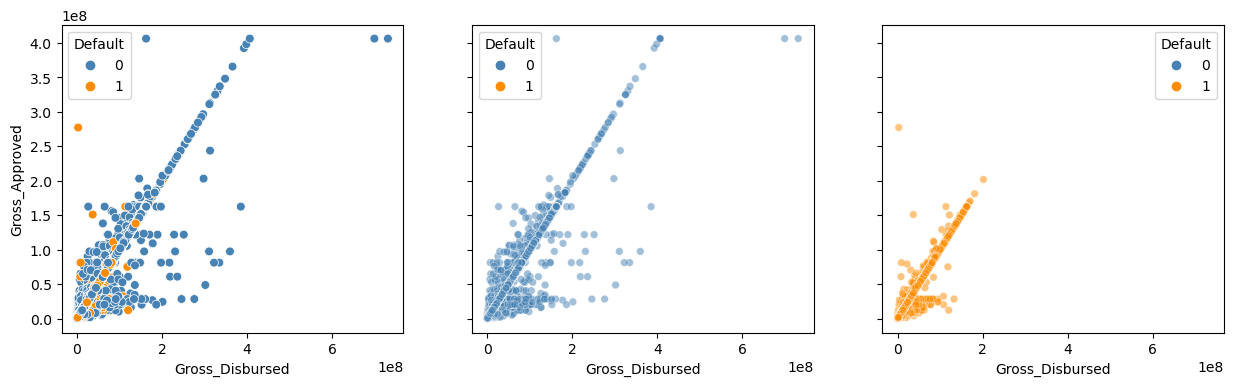

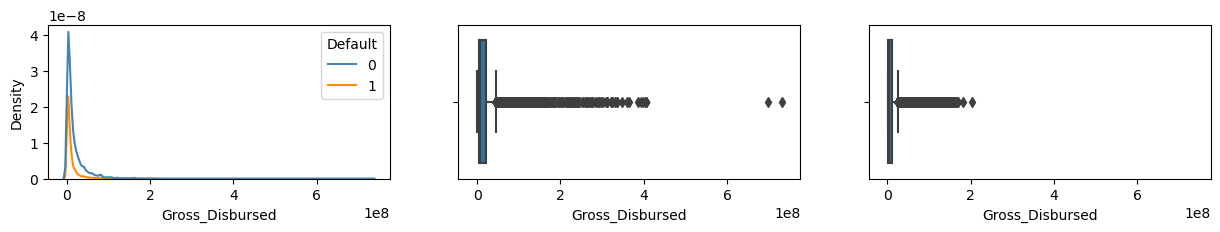

In [160]:
make_scatter('Gross_Disbursed','Gross_Approved','Default',kde=True, alpha=1)

#### Where loan > 1.6256e8

Non-zero values: 1405 (100.0% of total non null), null: 0
Upper whisker: 200761600.0, amount: 0
Lower whisker: 51856640.0, amount: 0


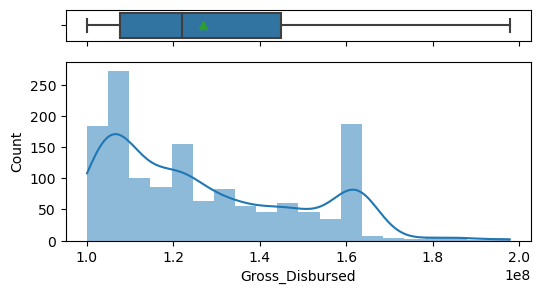

In [177]:
histbox(df.Gross_Disbursed[(df.Gross_Disbursed>1e8) & (df.Gross_Disbursed<2e8)])

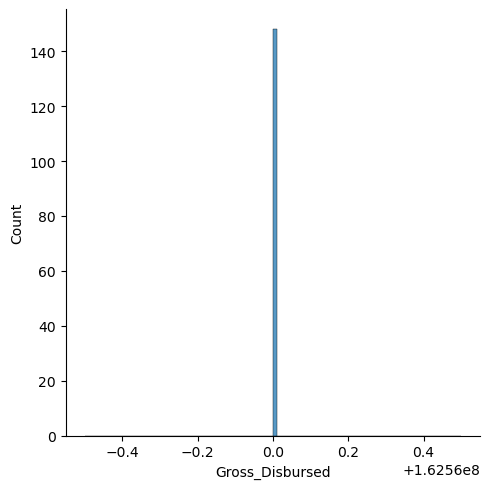

In [197]:
sns.displot(df.Gross_Disbursed[(df.Gross_Disbursed>1.6255e8) & (df.Gross_Disbursed<1.6257e8)], bins=100)

In [199]:
(df.Gross_Disbursed==1.6256e8).sum()

148

In [204]:
df[df.Gross_Disbursed>1.6256e8]

Business  Jobs_Reatained  Jobs_Created  Count_Employees  \
26      Existing              37            13               33   
736     Existing               0             0               99   
935     Existing               8             2                5   
2371         New               0           175                1   
2468    Existing              36            24               32   
...          ...             ...           ...              ...   
103860  Existing             116             0              104   
104044  Existing               0             9               18   
104483  Existing               9             8                1   
104753  Existing               0            45               40   
104915  Existing              45            45               40   

        Classification_Code  Code_Franchise Demography  Loan_Term  \
26                   721110               0      Rural        324   
736                       0               0  Undefined        270   
935                  423690               0      Urban        126   
2371                 311821               1      Rural        360   
2468                 531120               0      Urban        360   
...                     ...             ...        ...        ...   
103860               322299               0      Rural        180   
104044               336214               1      Urban        360   
104483               238210               1      Rural        126   
104753               332322               1      Urban        360   
104915                    0               1      Urban        126   

        Guaranteed_Approved  Gross_Approved  Gross_Disbursed  \
26             2.346960e+08     312928000.0     3.125216e+08   
736            6.078931e+07     219456000.0     2.194560e+08   
935            1.219200e+07      24384000.0     2.013128e+08   
2371           1.888947e+08     188894720.0     1.653235e+08   
2468           2.697683e+08     269768320.0     2.697683e+08   
...                     ...             ...              ...   
103860         1.767840e+08     235712000.0     2.357120e+08   
104044         1.833677e+08     183367680.0     1.833677e+08   
104483         1.422400e+07      28448000.0     2.758977e+08   
104753         1.797914e+08     179791360.0     1.671117e+08   
104915         6.095935e+07     182880000.0     1.828800e+08   

        Gross_Amount_Balance  ChargedOff_Amount Low_Documentation_Loan  \
26                       0.0                0.0                     No   
736                      0.0                0.0                     No   
935                      0.0                0.0                     No   
2371                     0.0                0.0                      C   
2468                     0.0                0.0                     No   
...                      ...                ...                    ...   
103860                   0.0                0.0                     No   
104044                   0.0                0.0                     No   
104483                   0.0                0.0                     No   
104753                   0.0                0.0                     No   
104915                   0.0                0.0                     No   

       Revolving_Credit_Line  Year_Of_Commitment  \
26                        No                2011   
736                       No                1989   
935                      Yes                2007   
2371                       0                2007   
2468                     NaN                2012   
...                      ...                 ...   
103860                    No                2011   
104044                     0                2007   
104483                   Yes                2006   
104753                     0                2006   
104915                     0                1999   

                         Borrower_Name Borrower_City  Borrower_State  \
26                 

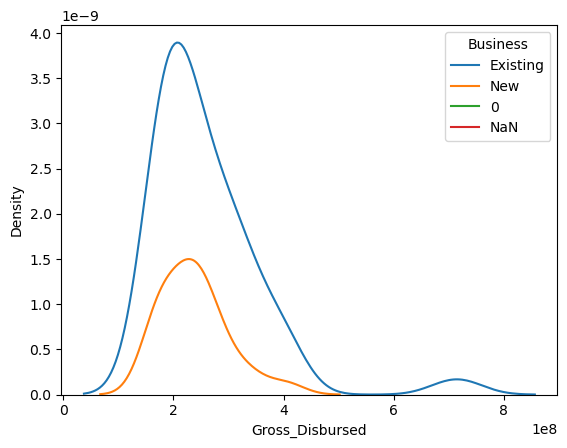

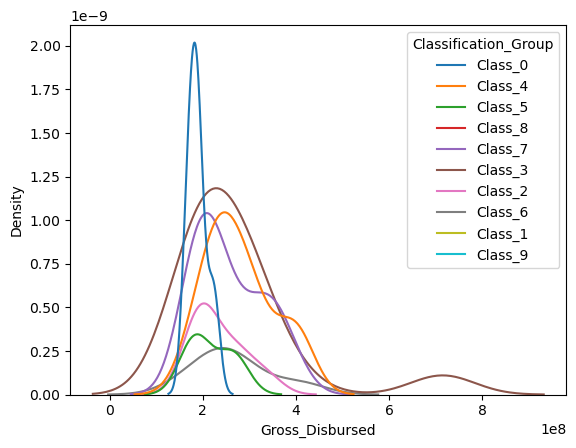

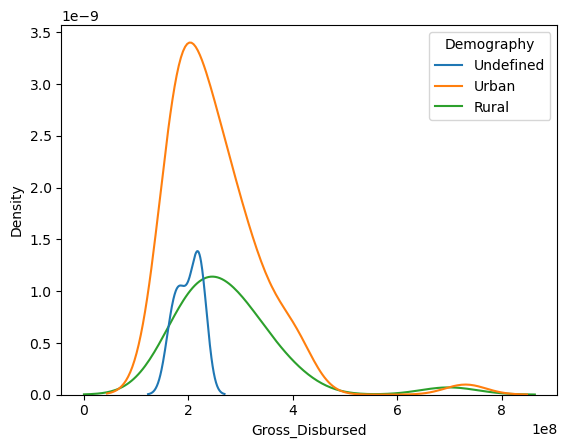

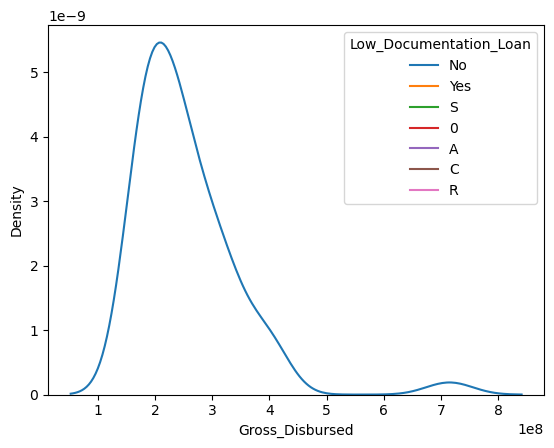

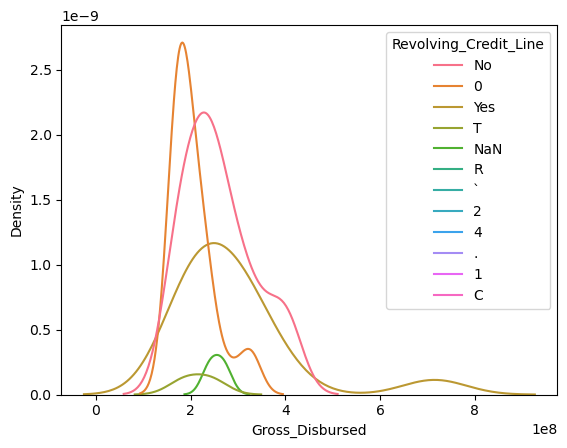

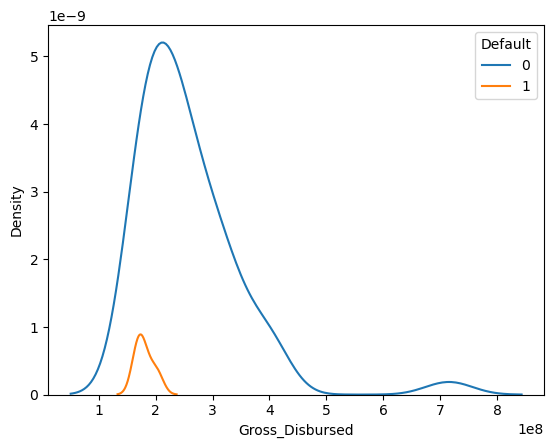

In [202]:
data_hue = ['Business', 'Classification_Group','Demography', 'Low_Documentation_Loan', 'Revolving_Credit_Line', 'Default']
data_x = 'Loan_Term'
data_y = df['Gross_Disbursed'][df.Gross_Disbursed>1.6256e8]

for data_hue in data_hue:
    if type(data_x) == str:
        data_x = df[data_x]
    if type(data_y) == str:
        data_y = df[data_y]
    if type(data_hue) == str:
        data_hue = df[data_hue]
    sns.kdeplot(data_y, hue = data_hue)
    plt.show()

### Year columns
remove 2

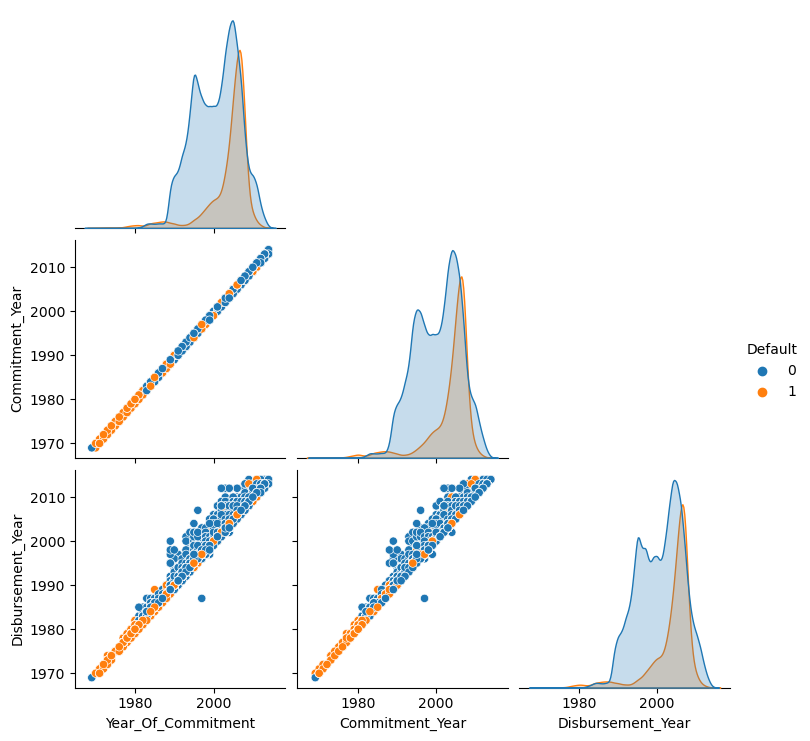

In [94]:
view_pairplot = ['Year_Of_Commitment', 'Commitment_Year', 'Disbursement_Year','Default']
sns.pairplot(df[view_pairplot] , hue='Default', corner = True)

<AxesSubplot:>

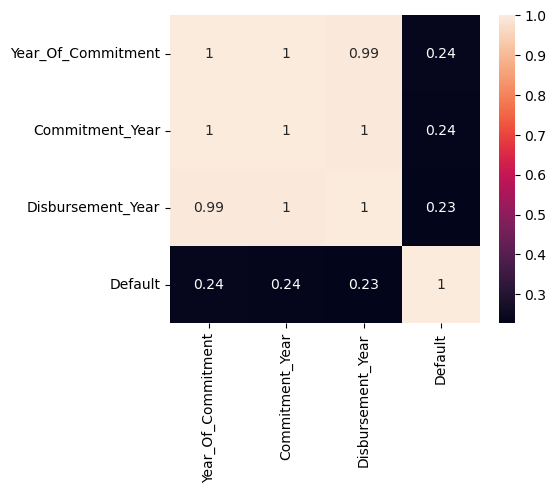

In [99]:
hm = ['Year_Of_Commitment', 'Commitment_Year', 'Disbursement_Year','Default']
plt.figure(figsize=(5,4))
sns.heatmap(df[hm].corr(), annot=True)

### 

### Loan term

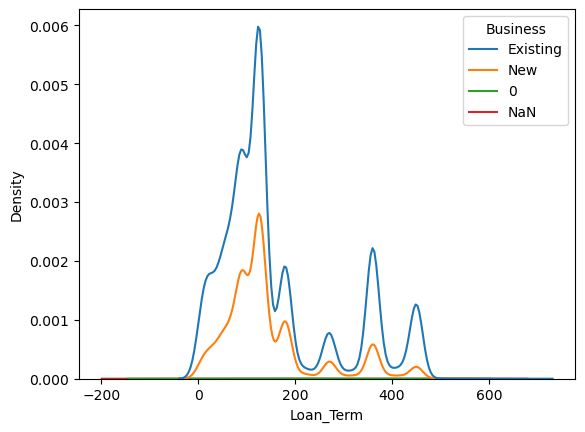

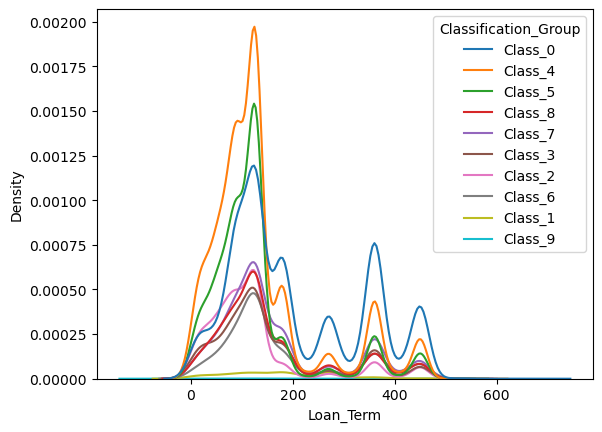

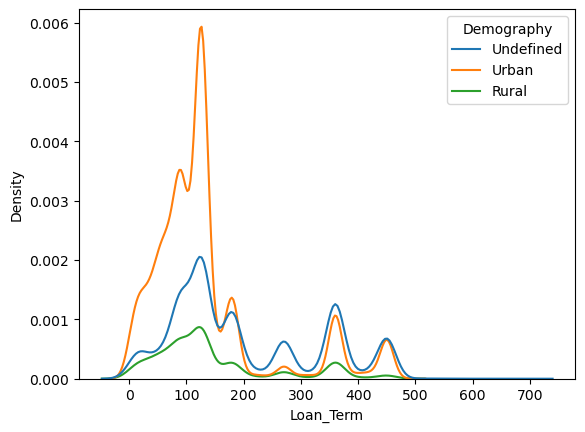

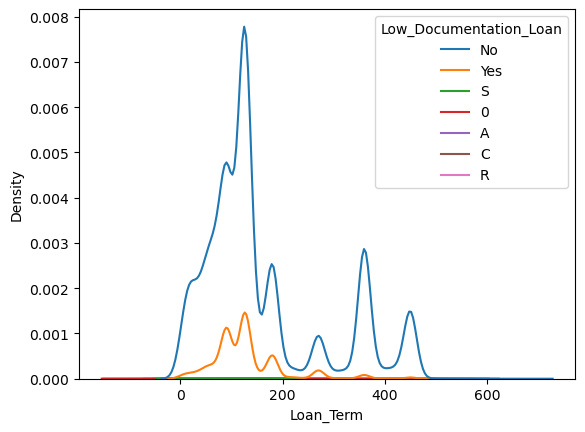

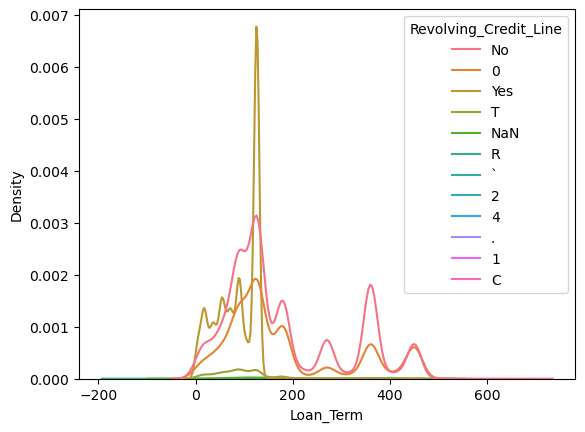

In [205]:
data_hue = ['Business', 'Classification_Group','Demography', 'Low_Documentation_Loan', 'Revolving_Credit_Line', ]
data_x = 'Loan_Term'
data_y = 'Gross_Disbursed'

for data_hue in data_hue:
    if type(data_x) == str:
        data_x = df[data_x]
    if type(data_y) == str:
        data_y = df[data_y]
    if type(data_hue) == str:
        data_hue = df[data_hue]
    sns.kdeplot(data_x, hue = data_hue)
    plt.show()

# 4. Null/pipeline for model

## 4.1 Preprocess + Null + Handle grouping